# Predição de séries temporais da COVID-19
### Casos confirmados

Autor: Saulo Leite

Dissertação: PREDIÇÃO DE SÉRIES TEMPORAIS DA COVID-19: UMA AVALIAÇÃO DO USO DOS MODELOS SUAVIZAÇÃO EXPONENCIAL, ARIMA, MLP & LSTM

### Importando bibliotecas
Para a implementação deste trabalho, foram necessárias muitas bibliotecas.

In [1]:
import math
import os
import datetime
import pandas
from pandas import read_csv
from pandas import Series
from pandas import datetime
from pandas.plotting import autocorrelation_plot
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import numpy

import keras
import tensorflow.keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\saulo\AppData\Local\Temp/ipykernel_8584/4274723594.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


### Tratamento de dados

Os dados usados neste trabalho são disponibilizados pela Universidade Johns Hopkins

# Implementação dos modelos LSTM e MLP



In [6]:
# converter uma matriz de valores em uma matriz de conjunto de dados
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#Criando dicionários para armazenamento de dados
#Dicionários LSMT
dts = dict() #Dicionário de datasets 
trpp = dict() #Dicionário de treinos
tspp = dict() #Dicionário de testes
trs = dict() #Dicionário de scores de treinos 
tss = dict() #Dicionário de scores de testes
tsm = dict() #Dicionário de MAES

#Valores selecionados (Melhores valores)
strpp = dict() #Dicionário de treinos
stspp = dict() #Dicionário de testes
strs = dict() #Dicionário de scores de treinos 
stss = {'Brasil':(9**15), 'Índia':(9**15), 'EUA':(9**15),'Itália':(9**15)} #Dicionário de scores de testes
stsm = {'Brasil':(9**15), 'Índia':(9**15), 'EUA':(9**15),'Itália':(9**15)} #Dicionário de MAE's Saída

#Dicionários MLP
dtsMLP = dict() #Dicionário de datasets 
trppMLP = dict() #Dicionário de treinos
tsppMLP = dict() #Dicionário de testes
trsMLP = dict() #Dicionário de scores de treinos 
tssMLP = dict() #Dicionário de scores de testes
t_aMLP = dict() #Dicionário de taxa de aprendizagem
tsmMLP = dict() #Dicionário de MAES

#Valores selecionados (Melhores valores)
strppMLP = dict() #Dicionário de treinos
stsppMLP = dict() #Dicionário de testes
strsMLP = dict() #Dicionário de scores de treinos 
stssMLP = {'Brasil':(9**15), 'Índia':(9**15), 'EUA':(9**15),'Itália':(9**15)} #Dicionário de scores de testes
stsmMLP = {'Brasil':(9**15), 'Índia':(9**15), 'EUA':(9**15),'Itália':(9**15)} #Dicionário de MAE's Saída

st_aMLP = dict() #Dicionário de taxa de aprendizagem saída

#Ajustes para seleção LSTM
t_a = dict() #Dicionário de taxa de aprendizagem
dropout = dict() #Dicionário de dropout
n_cel = dict() #Dicionário de número de células
st_a = dict() #Dicionário de taxa de aprendizagem saída
sdropout = dict() #Dicionário de dropout saída
sn_cel = dict() #Dicionário de número de células saída

#Ajustes para seleção MLP
t_a = dict() #Dicionário de taxa de aprendizagem
dropoutMLP = dict() #Dicionário de dropout
n_neu = dict() #Dicionário de número de neurônios
st_aMLP = dict() #Dicionário de taxa de aprendizagem saída
sdropoutMLP = dict() #Dicionário de dropout saída
sn_neu = dict() #Dicionário de número de neurônios

#Armazenando testes para plotagem somente dos testes
testP = dict()
testPMLP = dict()
stestPMLP = dict()
testPred = dict()
testPredMLP = dict()
stestPred = dict()
stestPredMLP = dict()

#Armazenando treinos para plotagem somente dos treinos
trainP = dict()
trainPMLP = dict()
strainPMLP = dict()
trainPred = dict()
trainPredMLP = dict()
strainPred = dict()
strainPredMLP = dict()

In [ ]:
country = ['Brasil', 'Índia', 'Itália', 'EUA'] #Lista de países

#Grid Search
T_A = [0.01, 0.05, 0.1, 0.2] #0.01, 0.02, 0,03, 0.06, 0.1, 0.2; 
DROP = [0.01, 0.05, 0.1, 0.2]   #0.05, 0.1, 0.15, 0.2, 0.3, 0.5;
N_C = [200, 300, 400, 600]    #50, 100, 200, 300, 400, 600;
NPC = [8, 16, 32, 64] #Neurônios por camada

#Relizando grade de experimentos
for i in range(len(country)):
                if country[i] == 'Brasil':
                    dataframe = read_csv('datasets/countries/casos_covid19_brazil.csv', usecols=[1], engine='python')
                    dataset = dataframe.values
                    dataset = dataset.astype('float32')
                if country[i] == 'Índia':
                    dataframe = read_csv('datasets/countries/casos_covid19_india.csv', usecols=[1], engine='python')
                    dataset = dataframe.values
                    dataset = dataset.astype('float32')
                if country[i] == 'Itália':
                    dataframe = read_csv('datasets/countries/casos_covid19_italy.csv', usecols=[1], engine='python')
                    dataset = dataframe.values
                    dataset = dataset.astype('float32')
                if country[i] == 'EUA':
                    dataframe = read_csv('datasets/countries/casos_covid19_us.csv', usecols=[1], engine='python')
                    dataset = dataframe.values
                    dataset = dataset.astype('float32')
                
                #LSTM
                
                # Normalizar o dataset
                scaler = MinMaxScaler(feature_range=(0, 1))
                dataset = scaler.fit_transform(dataset)
                # dividir em conjuntos de treinamento e teste
                train_size = int(len(dataset) * 0.67)
                test_size = len(dataset) - train_size
                train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
                # remodelar em X = t e Y = t + 1
                look_back = 1
                trainX, trainY = create_dataset(train, look_back)
                testX, testY = create_dataset(test, look_back)
                # remodelar a entrada para ser [amostras, intervalos de tempo, recursos]
                trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
                testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
                #Criando modelo
                model = Sequential()
                keras.backend.set_epsilon(1)
                #Adicionando camada LSTM e alguma regularização de Dropout 
                model.add(LSTM(units=int(N_C[k])))
                model.add(Dropout(float(DROP[j])))
                model.add(Dense(units=1, activation='linear'))
                #definindo hiper parâmetros
                adam = keras.optimizers.Adam(learning_rate=float(T_A[z]), beta_1=0.999, beta_2=0.999, amsgrad=False)
                model.compile(loss='mean_squared_error', optimizer='adam')
                model.fit(trainX, trainY, epochs=200, batch_size=40) #Mudar para 300 épocas - fora do grid search
                #fazer previsões
                trainPredict = model.predict(trainX)
                testPredict = model.predict(testX)
                # inverter previsões
                trainPredict = scaler.inverse_transform(trainPredict)
                trainY = scaler.inverse_transform([trainY])
                testPredict = scaler.inverse_transform(testPredict)
                testY = scaler.inverse_transform([testY])
                # calcular raiz quadrada média do erro
                trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
                print('Train Score: %.2f RMSE' % (trainScore))
                testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
                print('Test Score: %.2f RMSE' % (testScore))
                #Calcular o MAE:
                MAE = mean_absolute_error(testY[0], testPredict[:,0])
                # mudar para treinar previsões para traçar
                trainPredictPlot = numpy.empty_like(dataset)
                trainPredictPlot[:, :] = numpy.nan
                trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
                # previsões de teste de deslocamento para plotagem
                testPredictPlot = numpy.empty_like(dataset)
                testPredictPlot[:, :] = numpy.nan
                testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
                
                #MLP
                train_size = int(len(dataset) * 0.67)
                test_size = len(dataset) - train_size
                train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
                # remodelar em X = t e Y = t + 1
                look_back = 1
                trainX, trainY = create_dataset(train, look_back)
                testX, testY = create_dataset(test, look_back)
                # remodelar a entrada para ser [amostras, intervalos de tempo, recursos]
                trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
                testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
                model = Sequential()
                model.add(Dense(NPC[i], activation='sigmoid', input_dim = 1))
                model.add(Dropout(float(DROP[j])))
                model.add(Dense(NPC[i], activation='tanh'))
                model.add(Dropout(float(DROP[j])))
                model.add(Dense(NPC[i], activation='relu'))
                model.add(Dropout(float(DROP[j])))
                model.add(Dense(1))
                adam = keras.optimizers.Adam(learning_rate=float(T_A[z]))
                model.compile(optimizer=adam , loss='mean_squared_error')
                model.fit(trainX, trainY, epochs=200, batch_size = 40)
                #fazer previsões
                trainPredictMLP = model.predict(trainX)
                testPredictMLP = model.predict(testX)
                # inverter previsões
                trainPredictMLP = scaler.inverse_transform(trainPredictMLP)
                trainY = scaler.inverse_transform([trainY])
                testPredictMLP = scaler.inverse_transform(testPredictMLP)
                testY = scaler.inverse_transform([testY])
                # calcular raiz quadrada média do erro
                trainScoreMLP = math.sqrt(mean_squared_error(trainY[0], trainPredictMLP[:,0]))
                print('Train Score MLP: %.2f RMSE' % (trainScoreMLP))
                testScoreMLP = math.sqrt(mean_squared_error(testY[0], testPredictMLP[:,0]))
                print('Test Score MLP: %.2f RMSE' % (testScoreMLP))
                #Calcular o MAE:
                MAEMLP = mean_absolute_error(testY[0], testPredictMLP[:,0])
                # mudar para treinar previsões para traçar
                trainPredictPlotMLP = numpy.empty_like(dataset)
                trainPredictPlotMLP[:, :] = numpy.nan
                trainPredictPlotMLP[look_back:len(trainPredict)+look_back, :] = trainPredict
                # previsões de teste de deslocamento para plotagem
                testPredictPlotMLP = numpy.empty_like(dataset)
                testPredictPlotMLP[:, :] = numpy.nan
                testPredictPlotMLP[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


                #Armazenando as informações em dicionários LSTM
                tss[country[i]] = testScore
                tsm[country[i]] = MAE
                trpp[country[i]] = trainPredictPlot
                tspp[country[i]] = testPredictPlot
                trs[country[i]] = trainScore
                dts[country[i]] = scaler.inverse_transform(dataset)
                t_a[country[i]] = T_A[z]
                dropout[country[i]] = DROP[j]
                n_cel[country[i]] = N_C[k]
                tsm[country[i]] = MAE
                trainP[country[i]] = scaler.inverse_transform(train)
                testP[country[i]] = scaler.inverse_transform(test)
                trainPred[country[i]] = trainPredict
                testPred[country[i]] = testPredict
                
                if tss[country[i]] < stss[country[i]]: #Condição de verificação dos melhores resultados
                    strpp[country[i]] = trainPredictPlot
                    stspp[country[i]] = testPredictPlot
                    strs[country[i]] = trainScore
                    stss[country[i]] = testScore
                    st_a[country[i]] = T_A[z]
                    sdropout[country[i]] = DROP[j]
                    sn_cel[country[i]] = N_C[k]
                    stsm[country[i]] = MAE
                    strainPred[country[i]] = trainPredict
                    stestPred[country[i]] = testPredict
                    
                #Armazenando as informações em dicionários MLP
                tssMLP[country[i]] = testScoreMLP
                trppMLP[country[i]] = trainPredictPlotMLP
                tsppMLP[country[i]] = testPredictPlotMLP
                trsMLP[country[i]] = trainScoreMLP
                t_aMLP[country[i]] = T_A[z]
                dropoutMLP[country[i]] = DROP[j]
                n_neu[country[i]] = NPC[i]
                tsmMLP[country[i]] = MAEMLP
                trainPredMLP[country[i]] = trainPredictMLP
                testPredMLP[country[i]] = testPredictMLP


 LSTM - O melhor caso - Brasil 



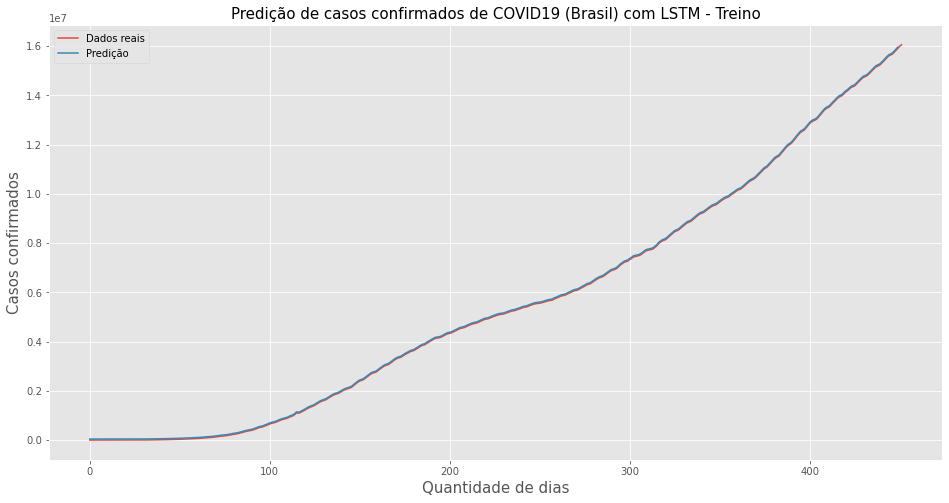

Train Score: 58933.07 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.1
Número de células: 600

 LSTM - O segundo melhor - Brasil 



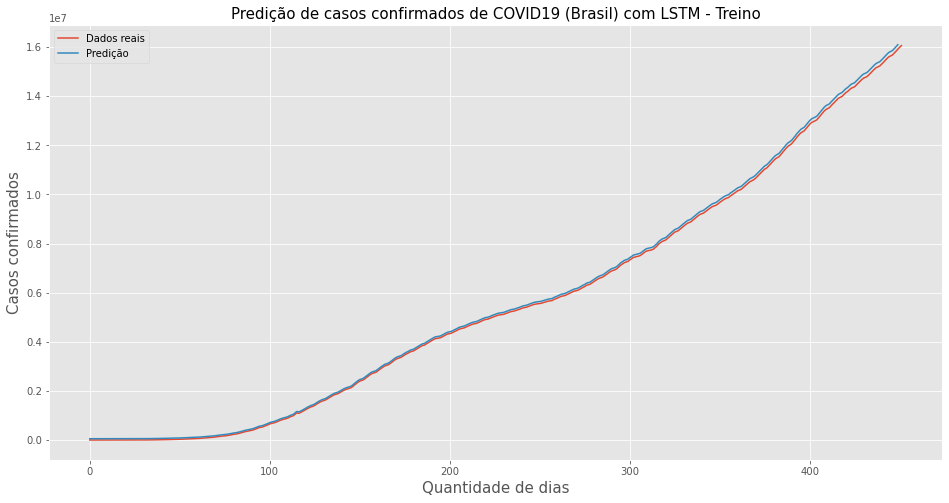

Train Score: 58933.07 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células: 600




 LSTM - O melhor caso - Índia 



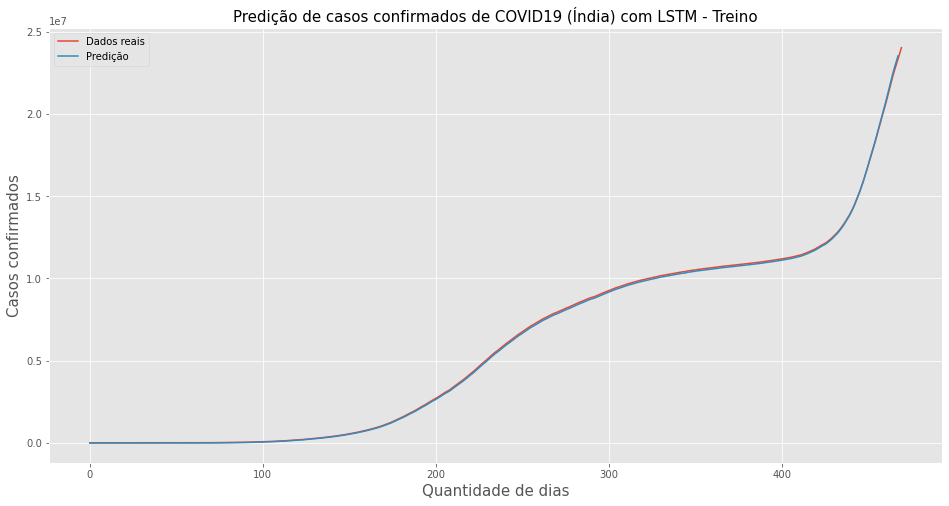

Train Score: 55598.81 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células: 200

 LSTM - O segundo melhor - Índia 



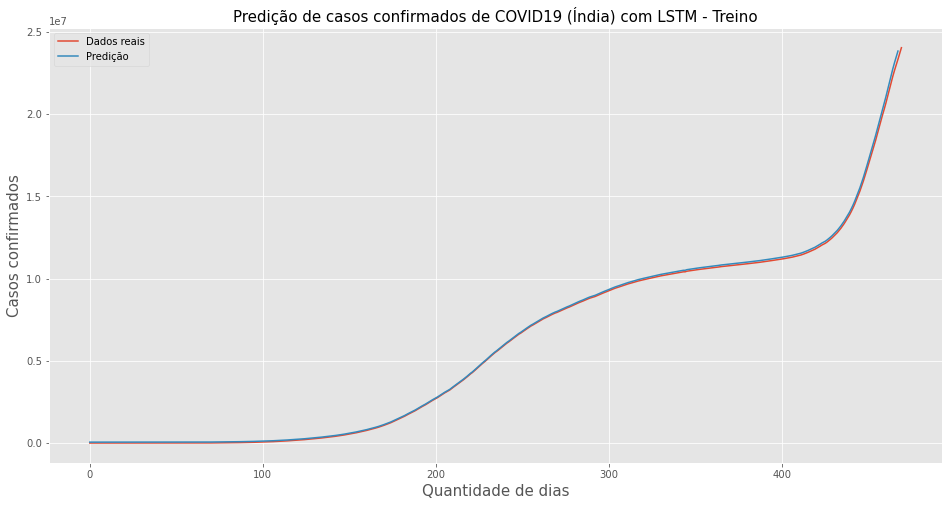

Train Score: 55598.81 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células: 600




 LSTM - O melhor caso - Itália 



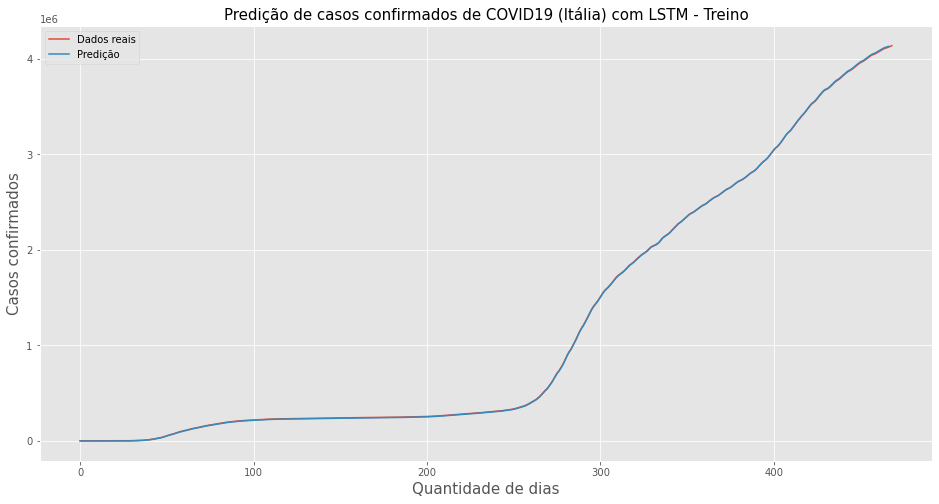

Train Score: 10706.54 RMSE
Taxa de aprendizagem: 0.1
Dropout: 0.1
Número de células: 200

 LSTM - O segundo melhor - Itália 



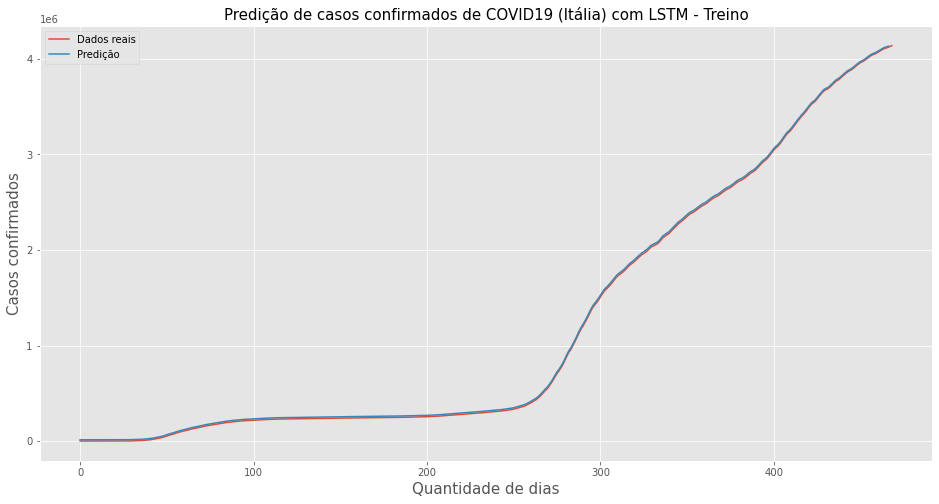

Train Score: 10706.54 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células: 600




 LSTM - O melhor caso - EUA 



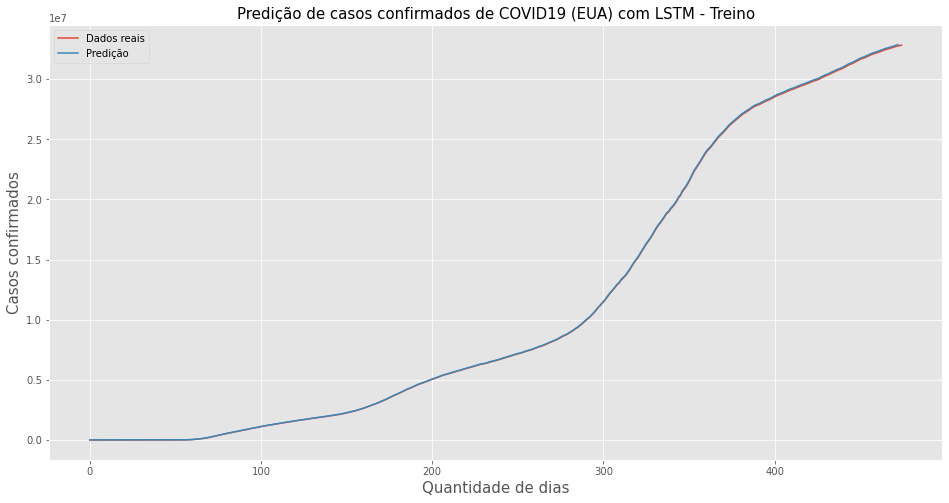

Train Score: 65002.27 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.01
Número de células: 300

 LSTM - O segundo melhor - EUA 



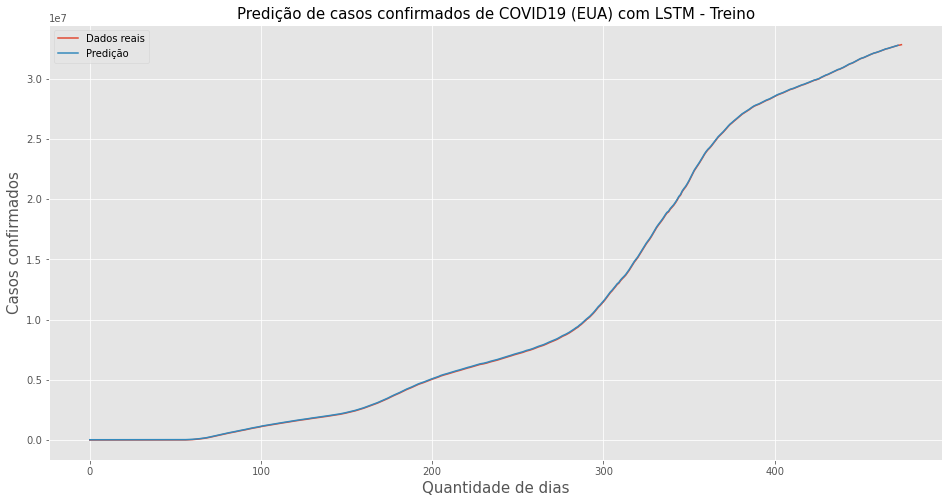

Train Score: 65002.27 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células: 600





In [25]:
#Plotar gráficos com os treinos LSTM
for i in range(len(country)): #loop de repatição apra mostrar todos os países
    print('\n LSTM - O melhor caso - %s \n' %(country[i]))
    plt.figure(figsize=(16,8))
    plt.title('Predição de casos confirmados de COVID19 (%s) com LSTM - Treino' %(country[i]), size = 15)
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Quantidade de dias', size = 15)
    plt.plot(trainP[country[i]], label = 'Dados reais')
    plt.plot(strainPred[country[i]], label = 'Predição')
    plt.legend()
    plt.show()
    print('Train Score: %.2f RMSE' % (trs[country[i]]))
    print('Taxa de aprendizagem:', st_a[country[i]])
    print('Dropout:', sdropout[country[i]])
    print('Número de células:', sn_cel[country[i]])

    print('\n LSTM - O segundo melhor - %s \n' %(country[i]))
    plt.figure(figsize=(16,8))
    plt.title('Predição de casos confirmados de COVID19 (%s) com LSTM - Treino' %(country[i]), size = 15)
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Quantidade de dias', size = 15)
    plt.plot(trainP[country[i]], label = 'Dados reais')
    plt.plot(trainPred[country[i]], label = 'Predição')
    plt.legend()
    plt.show()
    print('Train Score: %.2f RMSE' % (trs[country[i]]))
    print('Taxa de aprendizagem:', t_a[country[i]])
    print('Dropout:', dropout[country[i]])
    print('Número de células:', n_cel[country[i]])
    print('\n\n')



 LSTM - O melhor caso - Brasil 



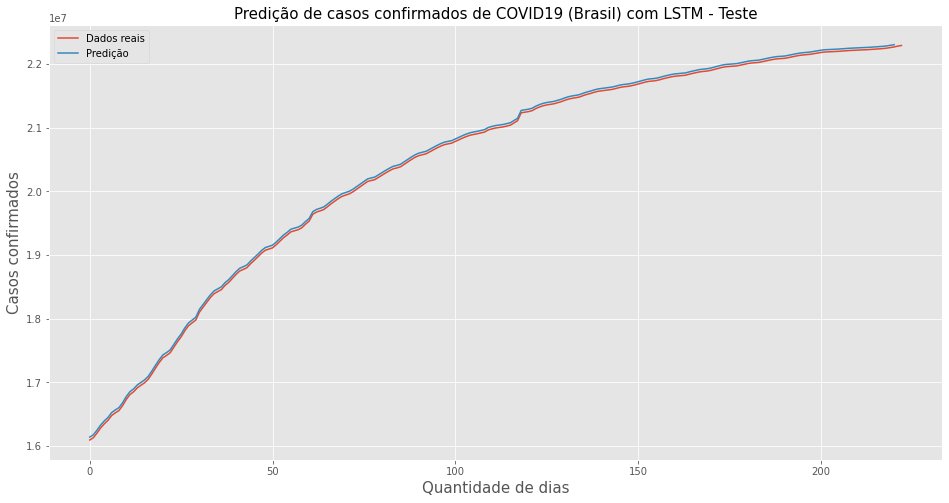

Test Score: 25283.47 RMSE
MAE: 21975.57023380769
Taxa de aprendizagem: 0.2
Dropout: 0.1
Número de células: 600

 LSTM - O segundo melhor - Brasil 



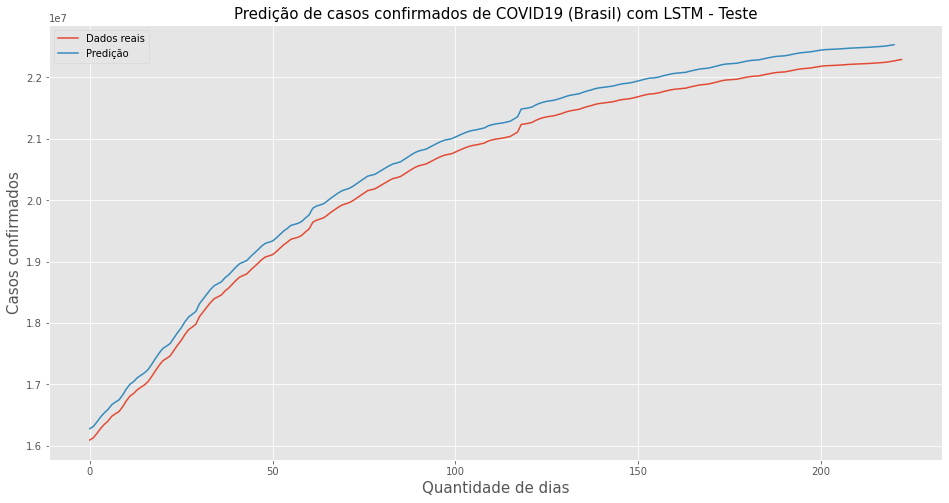

Test Score: 216945.92 RMSE
MAE: 212112.75097905908
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células: 600




 LSTM - O melhor caso - Índia 



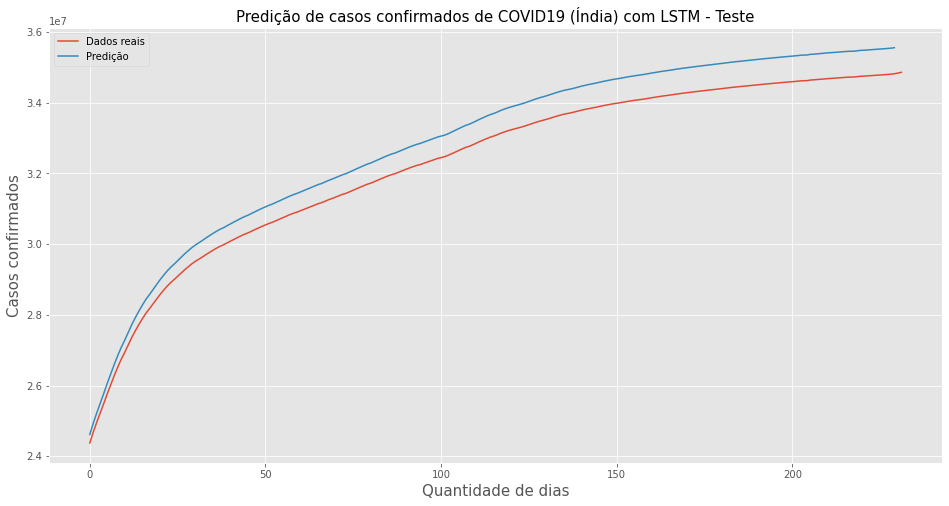

Test Score: 584442.07 RMSE
MAE: 559053.719440499
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células: 200

 LSTM - O segundo melhor - Índia 



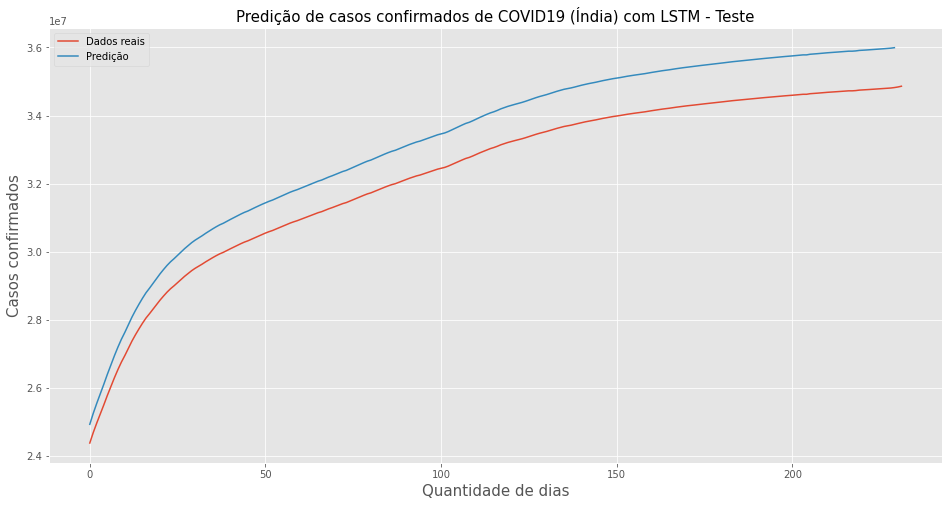

Test Score: 981658.57 RMSE
MAE: 960313.3358834797
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células: 600




 LSTM - O melhor caso - Itália 



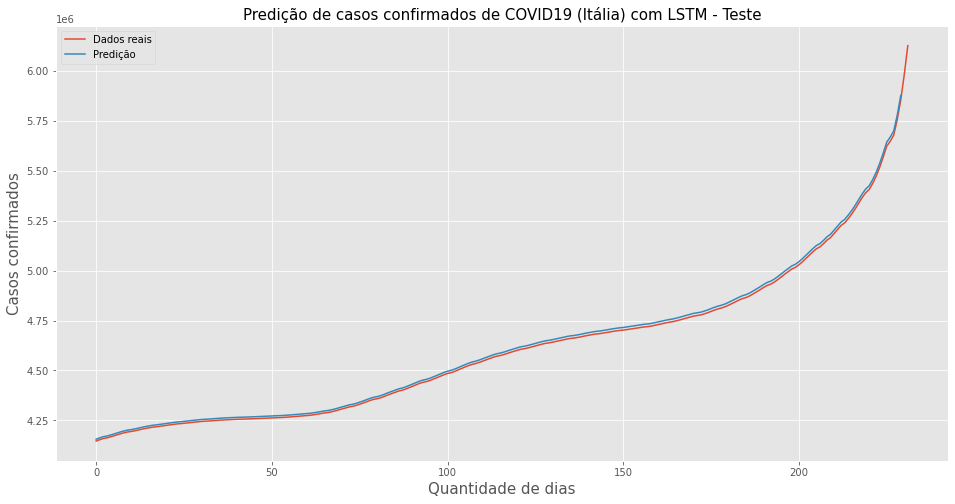

Test Score: 12436.33 RMSE
MAE: 8263.079880942687
Taxa de aprendizagem: 0.1
Dropout: 0.1
Número de células: 200

 LSTM - O segundo melhor - Itália 



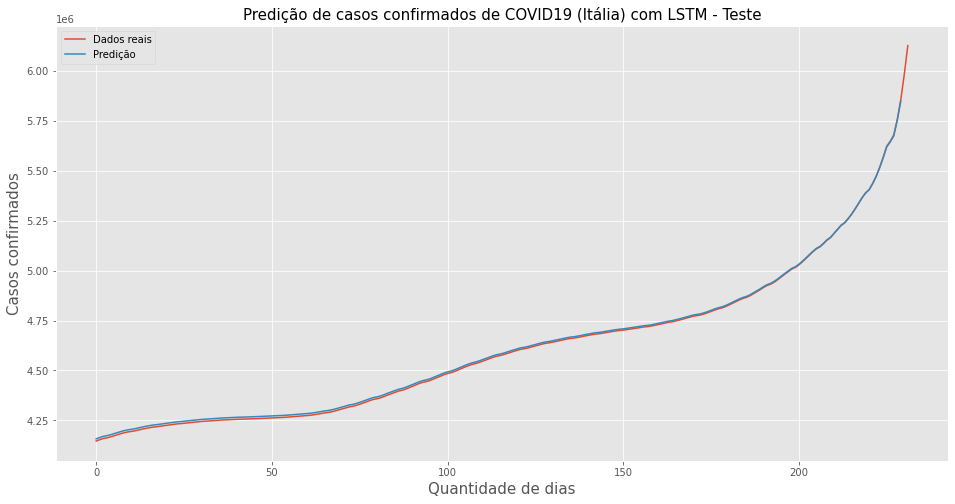

Test Score: 16296.28 RMSE
MAE: 8373.676575371785
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células: 600




 LSTM - O melhor caso - EUA 



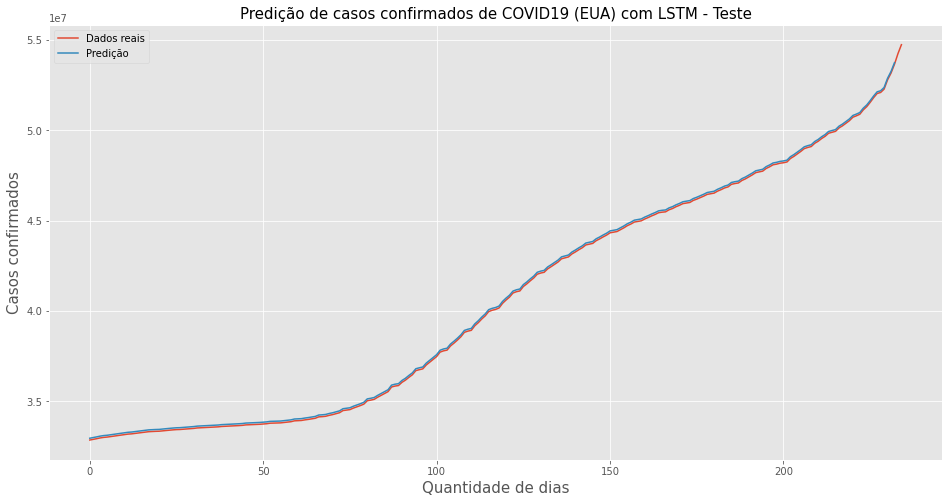

Test Score: 87661.82 RMSE
MAE: 66605.27777256379
Taxa de aprendizagem: 0.2
Dropout: 0.01
Número de células: 300

 LSTM - O segundo melhor - EUA 



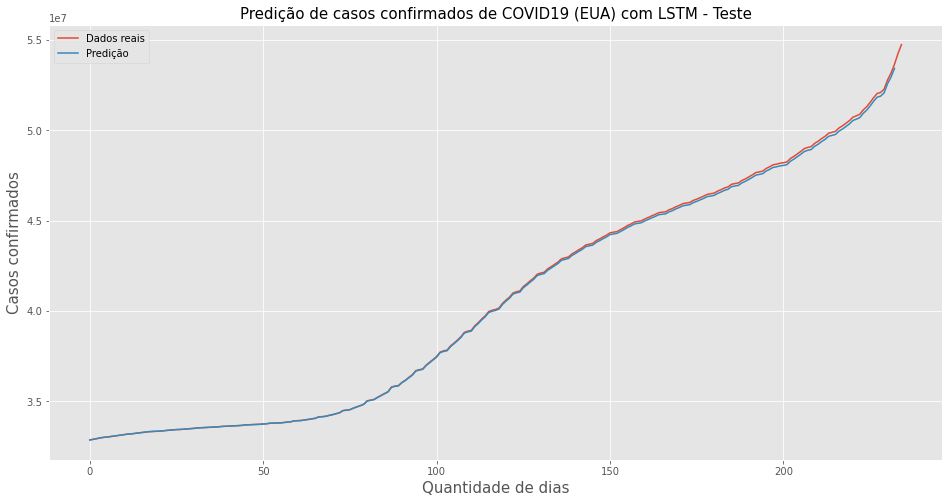

Test Score: 207030.92 RMSE
MAE: 159252.61580359144
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células: 600





In [26]:
#Plotar gráficos com os testes LSTM
for i in range(len(country)): #loop de repatição apra mostrar todos os países
    print('\n LSTM - O melhor caso - %s \n' %(country[i]))
    plt.figure(figsize=(16,8))
    plt.title('Predição de casos confirmados de COVID19 (%s) com LSTM - Teste' %(country[i]), size = 15)
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Quantidade de dias', size = 15)
    plt.plot(testP[country[i]], label = 'Dados reais')
    plt.plot(stestPred[country[i]], label = 'Predição')
    plt.legend()
    plt.show()
    print('Test Score: %.2f RMSE' % (stss[country[i]]))
    print('MAE:', stsm[country[i]])
    print('Taxa de aprendizagem:', st_a[country[i]])
    print('Dropout:', sdropout[country[i]])
    print('Número de células:', sn_cel[country[i]])

    print('\n LSTM - O segundo melhor - %s \n' %(country[i]))
    plt.figure(figsize=(16,8))
    plt.title('Predição de casos confirmados de COVID19 (%s) com LSTM - Teste' %(country[i]), size = 15)
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Quantidade de dias', size = 15)
    plt.plot(testP[country[i]], label = 'Dados reais')
    plt.plot(testPred[country[i]], label = 'Predição')
    plt.legend()
    plt.show()
    print('Test Score: %.2f RMSE' % (tss[country[i]]))
    print('MAE:', tsm[country[i]])
    print('Taxa de aprendizagem:', t_a[country[i]])
    print('Dropout:', dropout[country[i]])
    print('Número de células:', n_cel[country[i]])
    print('\n\n')



 LSTM - O melhor caso - Brasil 



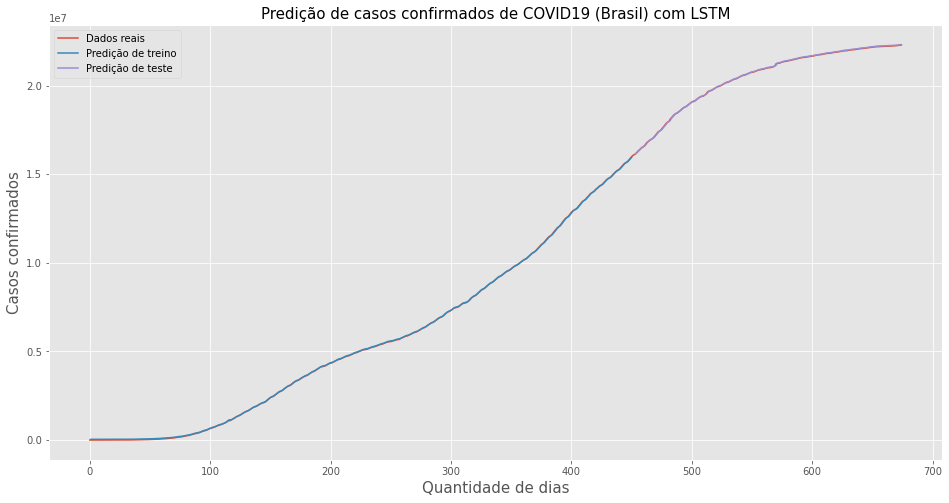

Train Score: 24079.53 RMSE
Test Score: 25283.47 RMSE
MAE: 21975.57023380769
Taxa de aprendizagem: 0.2
Dropout: 0.1
Número de células: 600

 LSTM - O segundo melhor - Brasil 



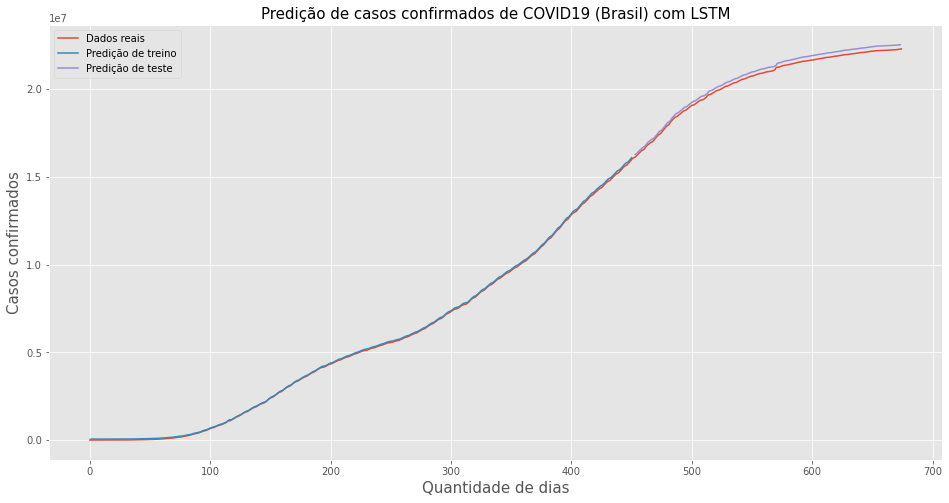

Train Score: 58933.07 RMSE
Test Score: 216945.92 RMSE
MAE: 212112.75097905908
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células: 600




 LSTM - O melhor caso - Índia 



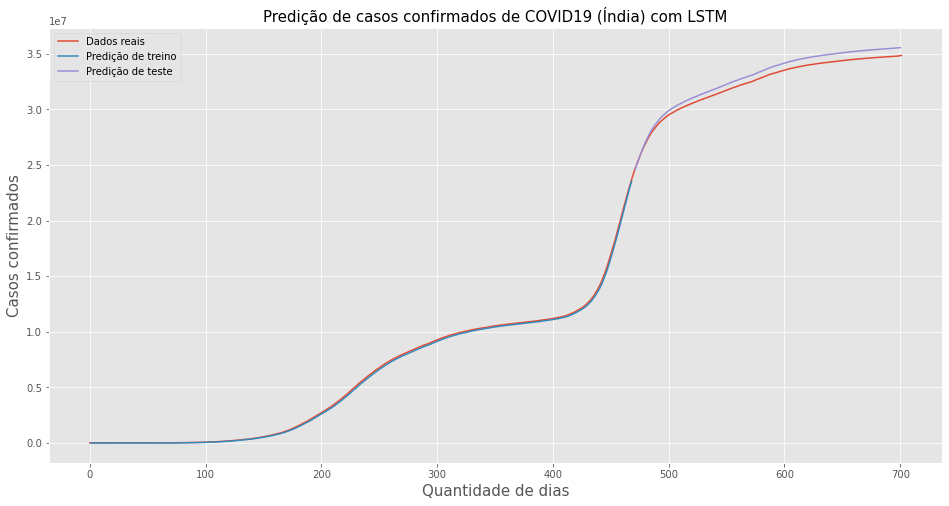

Train Score: 123895.43 RMSE
Test Score: 584442.07 RMSE
MAE: 559053.719440499
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células: 200

 LSTM - O segundo melhor - Índia 



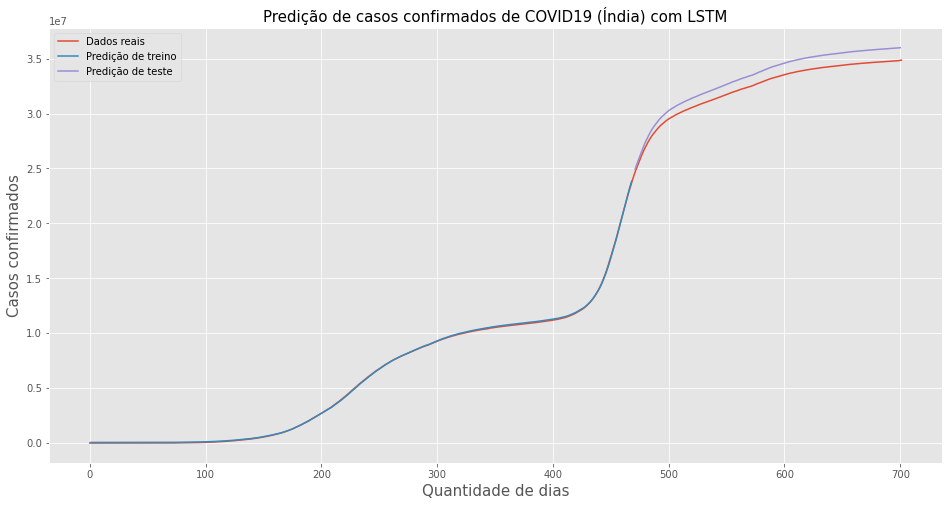

Train Score: 55598.81 RMSE
Test Score: 981658.57 RMSE
MAE: 960313.3358834797
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células: 600




 LSTM - O melhor caso - Itália 



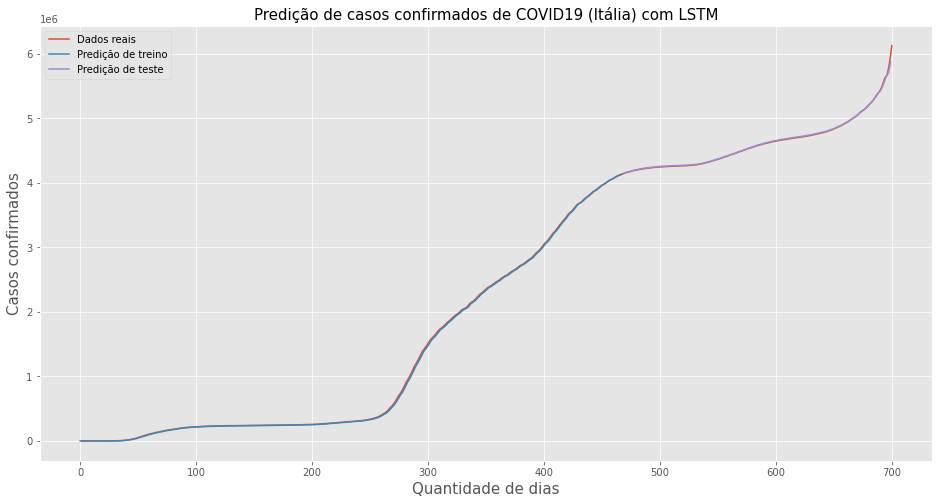

Train Score: 14304.55 RMSE
Test Score: 12436.33 RMSE
MAE: 8263.079880942687
Taxa de aprendizagem: 0.1
Dropout: 0.1
Número de células: 200

 LSTM - O segundo melhor - Itália 



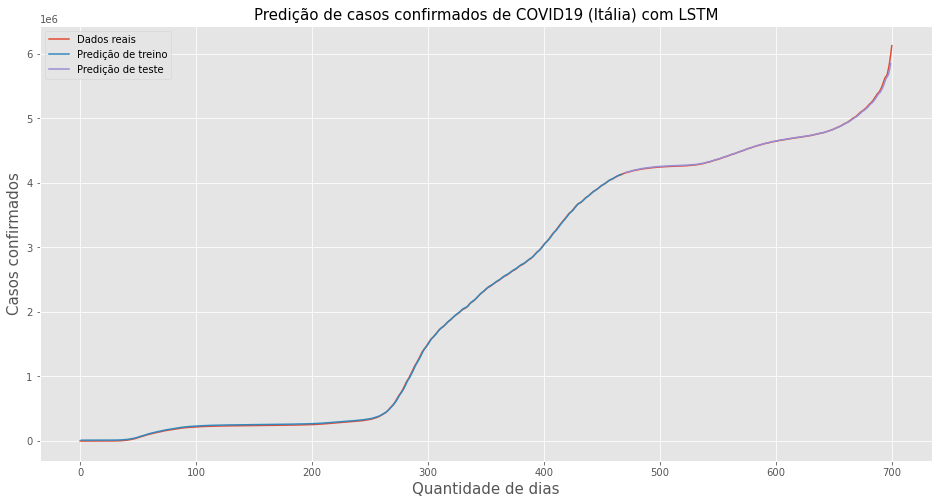

Train Score: 10706.54 RMSE
Test Score: 16296.28 RMSE
MAE: 8373.676575371785
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células: 600




 LSTM - O melhor caso - EUA 



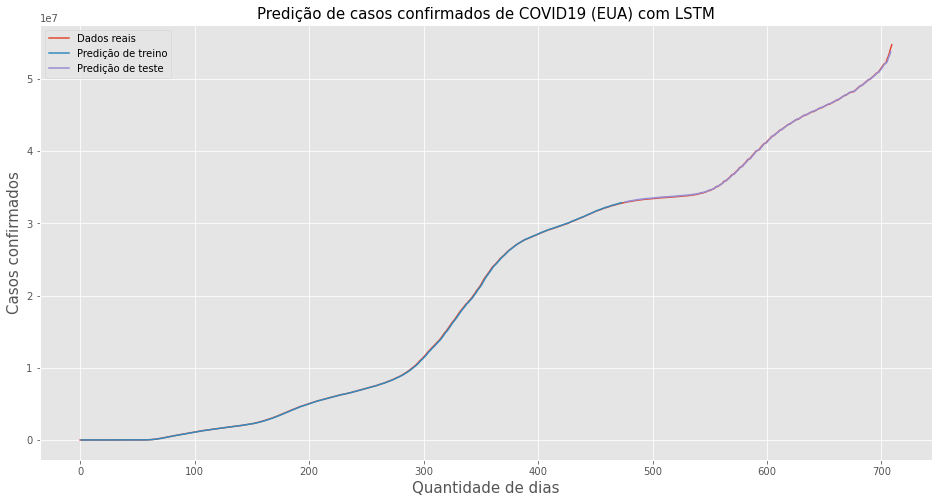

Train Score: 62239.74 RMSE
Test Score: 87661.82 RMSE
MAE: 66605.27777256379
Taxa de aprendizagem: 0.2
Dropout: 0.01
Número de células: 300

 LSTM - O segundo melhor - EUA 



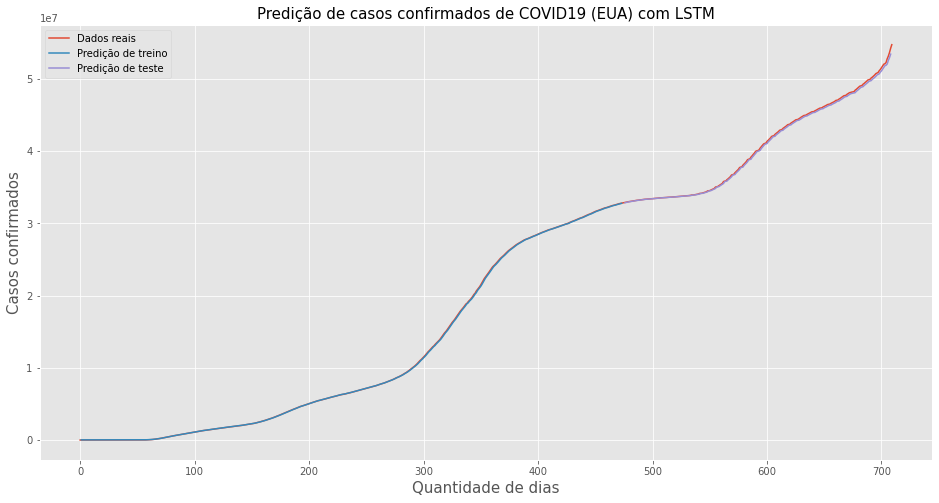

Train Score: 65002.27 RMSE
Test Score: 207030.92 RMSE
MAE: 159252.61580359144
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células: 600





In [27]:
#Plotar gráficos com base nas previsões do modelo LSTM
for i in range(len(country)): #loop de repatição apra mostrar todos os países
    
    print('\n LSTM - O melhor caso - %s \n' %(country[i]))
    plt.figure(figsize=(16,8))
    plt.title('Predição de casos confirmados de COVID19 (%s) com LSTM' %(country[i]), size = 15)
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Quantidade de dias', size = 15)
    plt.plot(dts[country[i]], label = 'Dados reais')
    plt.plot(strpp[country[i]], label = 'Predição de treino')
    plt.plot(stspp[country[i]], label = 'Predição de teste')
    plt.legend()
    plt.show()
    print('Train Score: %.2f RMSE' % (strs[country[i]]))
    print('Test Score: %.2f RMSE' % (stss[country[i]]))
    print('MAE:', stsm[country[i]])
    print('Taxa de aprendizagem:', st_a[country[i]])
    print('Dropout:', sdropout[country[i]])
    print('Número de células:', sn_cel[country[i]])

    print('\n LSTM - O segundo melhor - %s \n' %(country[i]))
    plt.figure(figsize=(16,8))
    plt.title('Predição de casos confirmados de COVID19 (%s) com LSTM' %(country[i]), size = 15)
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Quantidade de dias', size = 15)
    plt.plot(dts[country[i]], label = 'Dados reais')
    plt.plot(trpp[country[i]], label = 'Predição de treino')
    plt.plot(tspp[country[i]], label = 'Predição de teste')
    plt.legend()
    plt.show()
    print('Train Score: %.2f RMSE' % (trs[country[i]]))
    print('Test Score: %.2f RMSE' % (tss[country[i]]))
    print('MAE:', tsm[country[i]])
    print('Taxa de aprendizagem:', t_a[country[i]])
    print('Dropout:', dropout[country[i]])
    print('Número de células:', n_cel[country[i]])
    print('\n\n')
    
    #Armazenando dados de treino e teste da predição
    if country[i] == 'Brasil':
        st = strpp[country[i]]
        ts = stspp[country[i]]
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/test/out_lstm_casos_test_brazil.csv',st,delimiter=',')
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/train/out_lstm_casos_train_brazil.csv',ts,delimiter=',')
    if country[i] == 'Índia':
        st = strpp[country[i]]
        ts = stspp[country[i]]
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/test/out_lstm_casos_test_india.csv',st,delimiter=',')
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/train/out_lstm_casos_train_india.csv',ts,delimiter=',')
    if country[i] == 'Itália':
        st = strpp[country[i]]
        ts = stspp[country[i]]
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/test/out_lstm_casos_test_italia.csv',st,delimiter=',')
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/train/out_lstm_casos_train_italia.csv',ts,delimiter=',')
    if country[i] == 'EUA':
        st = strpp[country[i]]
        ts = stspp[country[i]]
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/test/out_lstm_casos_test_eua.csv',st,delimiter=',')
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/train/out_lstm_casos_train_eua.csv',ts,delimiter=',')


 MLP - O melhor caso - Brasil 



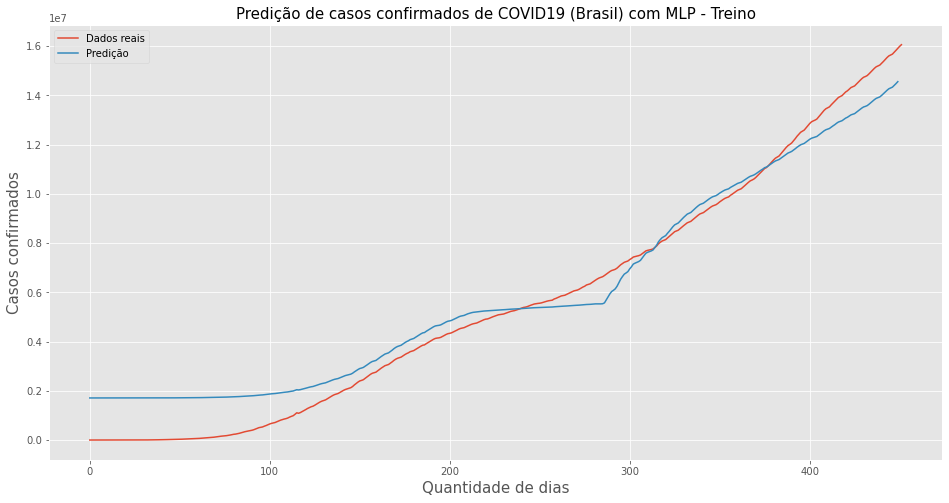

Train Score: 956955.99 RMSE
Taxa de aprendizagem: 0.1
Dropout: 0.2
Número de células por camada: 8

 MLP - O segundo melhor - Brasil 



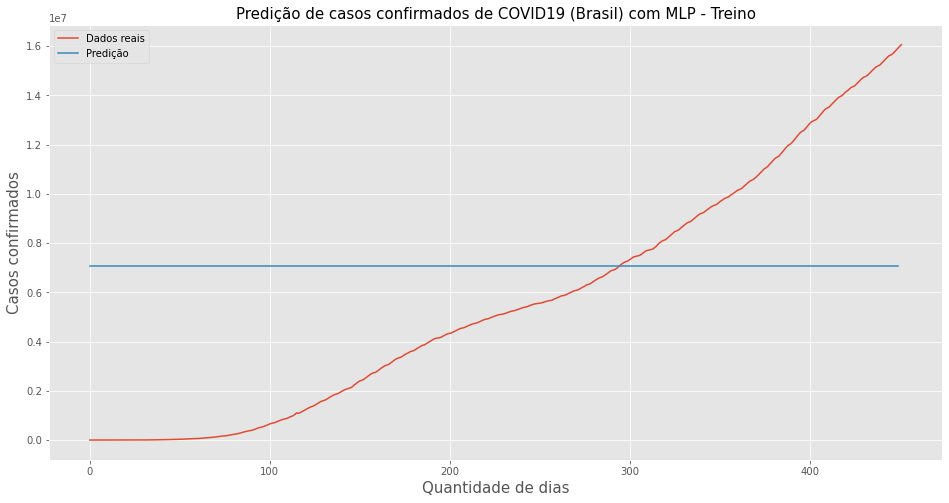

Train Score: 4970356.79 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células por camada: 8




 MLP - O melhor caso - Índia 



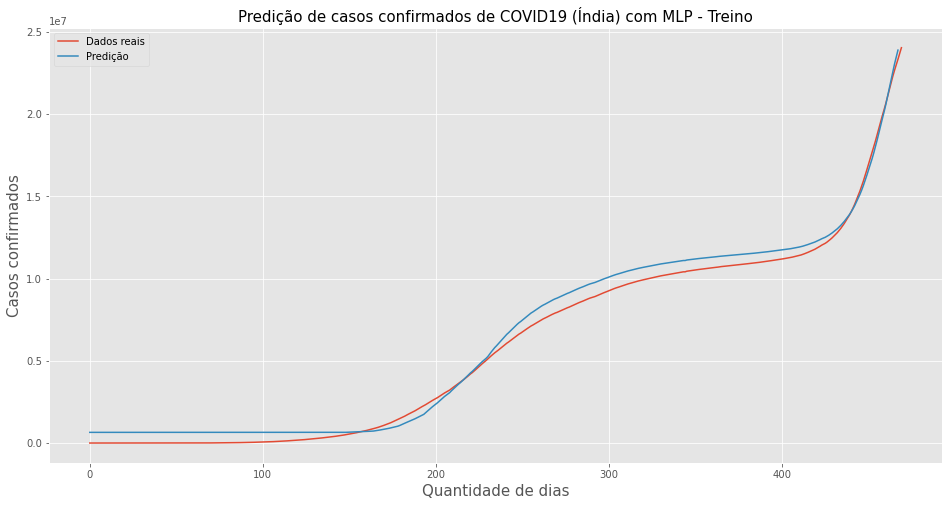

Train Score: 567785.85 RMSE
Taxa de aprendizagem: 0.05
Dropout: 0.1
Número de células por camada: 16

 MLP - O segundo melhor - Índia 



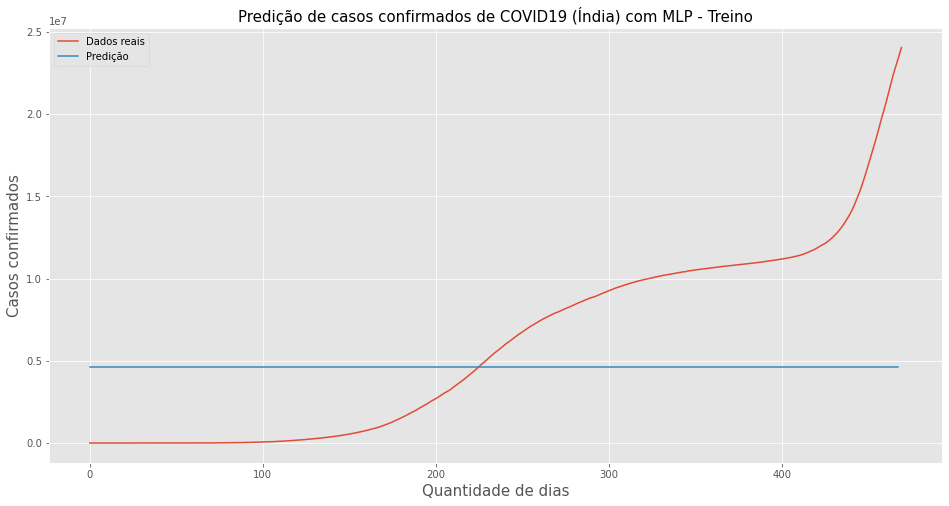

Train Score: 5815261.49 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células por camada: 16




 MLP - O melhor caso - Itália 



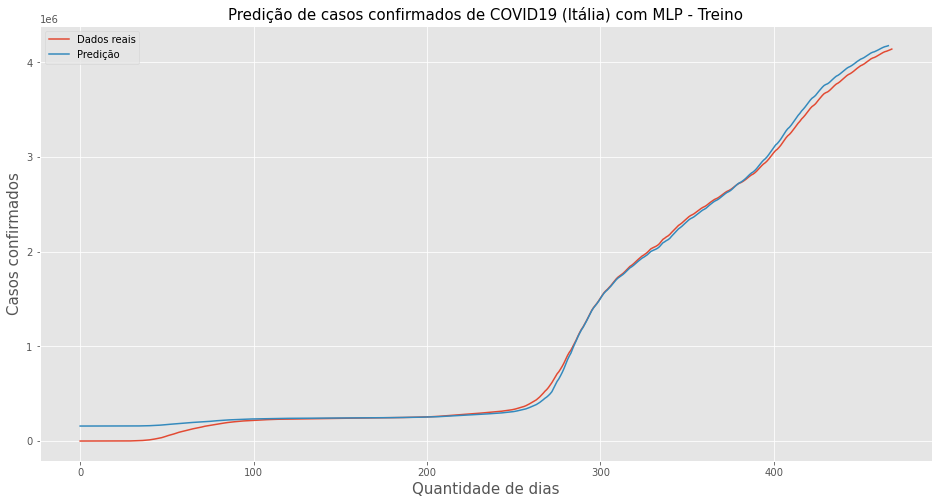

Train Score: 64537.91 RMSE
Taxa de aprendizagem: 0.01
Dropout: 0.01
Número de células por camada: 32

 MLP - O segundo melhor - Itália 



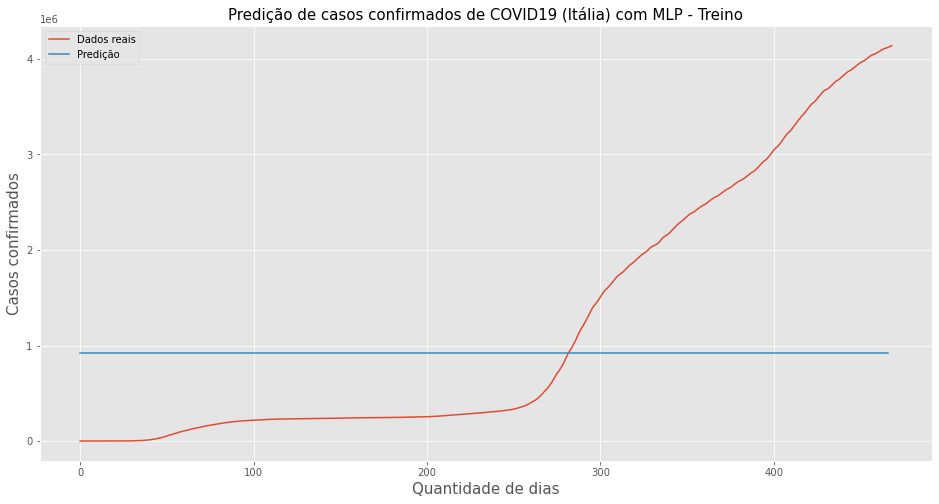

Train Score: 1370134.27 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células por camada: 32




 MLP - O melhor caso - EUA 



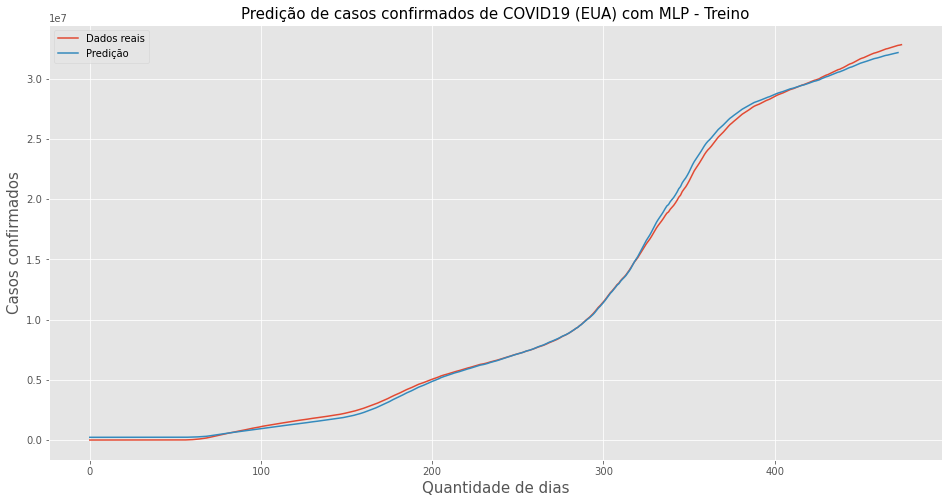

Train Score: 280513.35 RMSE
Taxa de aprendizagem: 0.01
Dropout: 0.01
Número de células por camada: 64

 MLP - O segundo melhor - EUA 



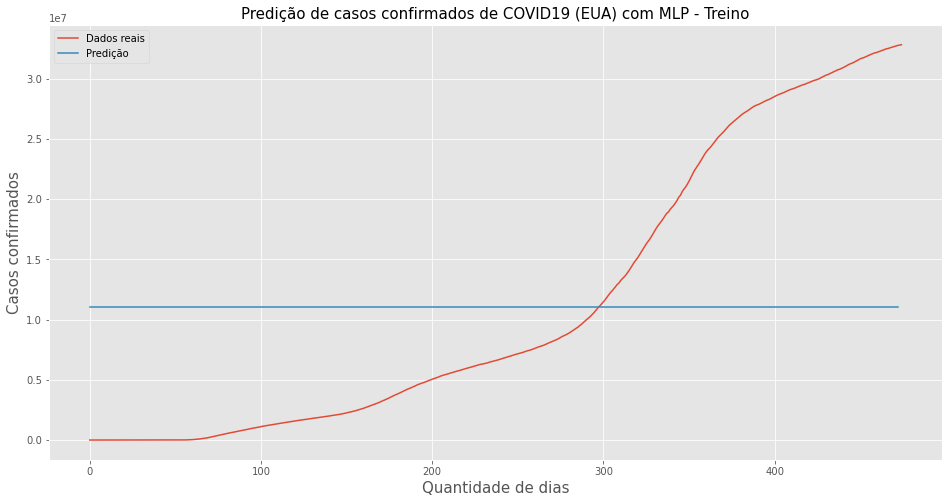

Train Score: 11459562.62 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células por camada: 64





In [28]:
#Plotar gráficos com treinos do modelo MLP
for i in range(len(country)):
    print('\n MLP - O melhor caso - %s \n' %(country[i]))
    plt.figure(figsize=(16,8))
    plt.title('Predição de casos confirmados de COVID19 (%s) com MLP - Treino' %(country[i]), size = 15)
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Quantidade de dias', size = 15)

    plt.plot(trainP[country[i]], label = 'Dados reais')
    plt.plot(strainPredMLP[country[i]], label = 'Predição')
    plt.legend()
    plt.show()
    print('Train Score: %.2f RMSE' % (strsMLP[country[i]]))
    print('Taxa de aprendizagem:', st_aMLP[country[i]])
    print('Dropout:', sdropoutMLP[country[i]])
    print('Número de células por camada:',sn_neu[country[i]])


    print('\n MLP - O segundo melhor - %s \n' %(country[i]))
    plt.figure(figsize=(16,8))
    plt.title('Predição de casos confirmados de COVID19 (%s) com MLP - Treino' %(country[i]), size = 15)
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Quantidade de dias', size = 15)
    plt.plot(trainP[country[i]], label = 'Dados reais')
    plt.plot(trainPredMLP[country[i]], label = 'Predição')
    plt.legend()
    plt.show()
    print('Train Score: %.2f RMSE' % (trsMLP[country[i]]))
    print('Taxa de aprendizagem:', t_aMLP[country[i]])
    print('Dropout:', dropoutMLP[country[i]])

    print('Número de células por camada:',n_neu[country[i]])
 
    print('\n\n')


 MLP - O melhor caso - Brasil 



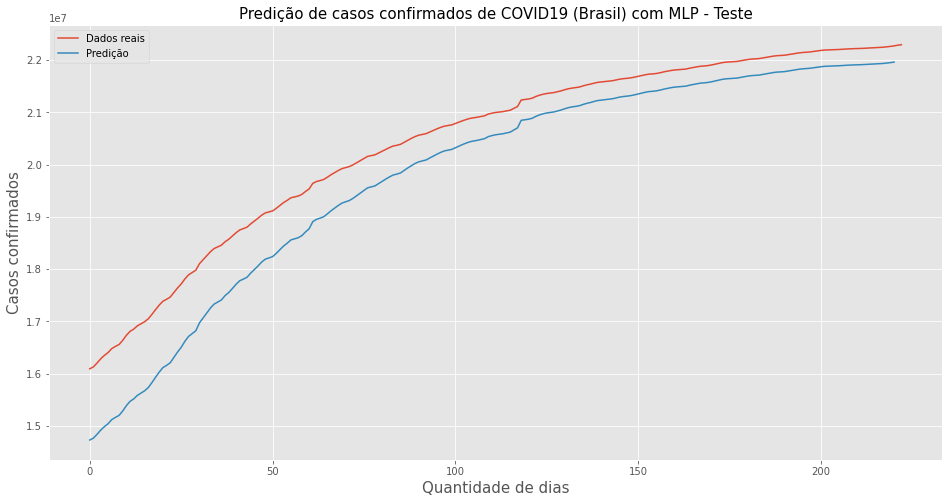

Test Score: 728409.38 RMSE
MAE: 628033.4209666422
Taxa de aprendizagem: 0.1
Dropout: 0.2
Número de células por camada: 8

 MLP - O segundo melhor - Brasil 



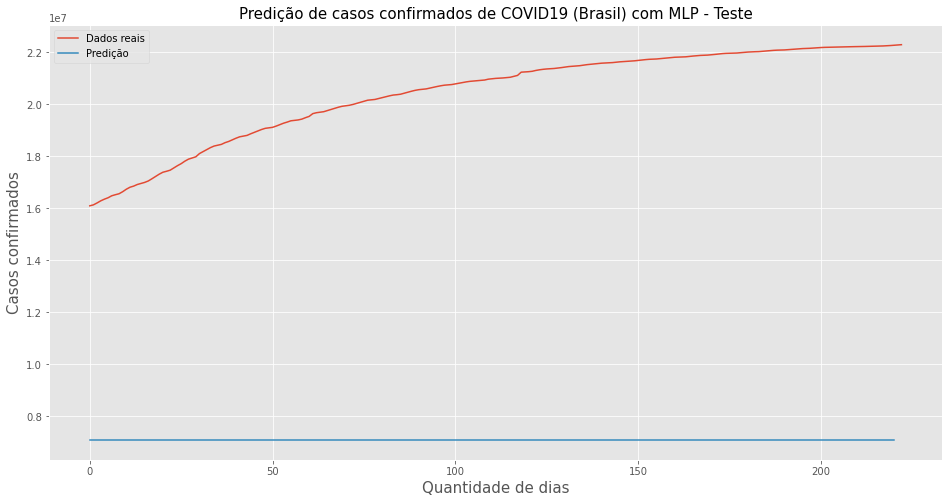

Test Score: 13475018.71 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
MAE: 13365020.022776594
Número de células por camada: 8




 MLP - O melhor caso - Índia 



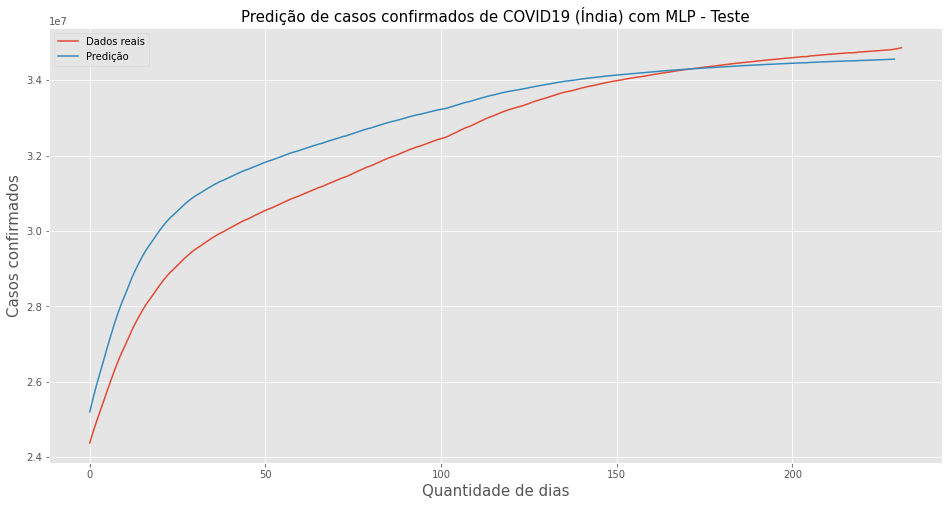

Test Score: 778756.96 RMSE
MAE: 616552.0811606005
Taxa de aprendizagem: 0.05
Dropout: 0.1
Número de células por camada: 16

 MLP - O segundo melhor - Índia 



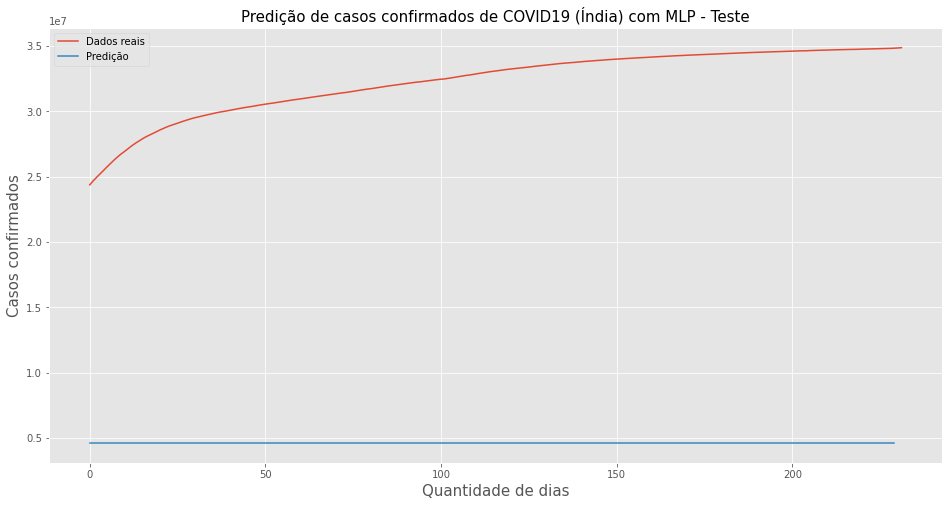

Test Score: 27797348.20 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
MAE: 27695077.277159996
Número de células por camada: 16




 MLP - O melhor caso - Itália 



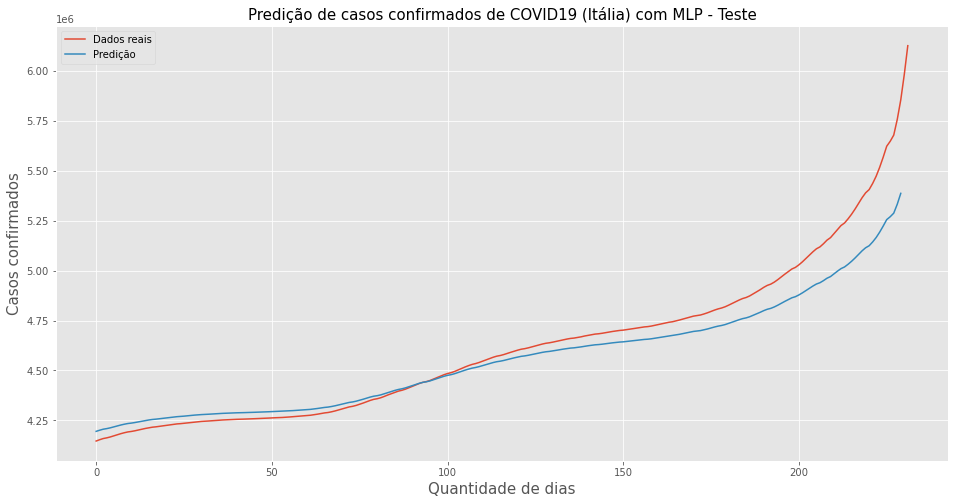

Test Score: 123301.96 RMSE
MAE: 78405.04347418065
Taxa de aprendizagem: 0.01
Dropout: 0.01
Número de células por camada: 32

 MLP - O segundo melhor - Itália 



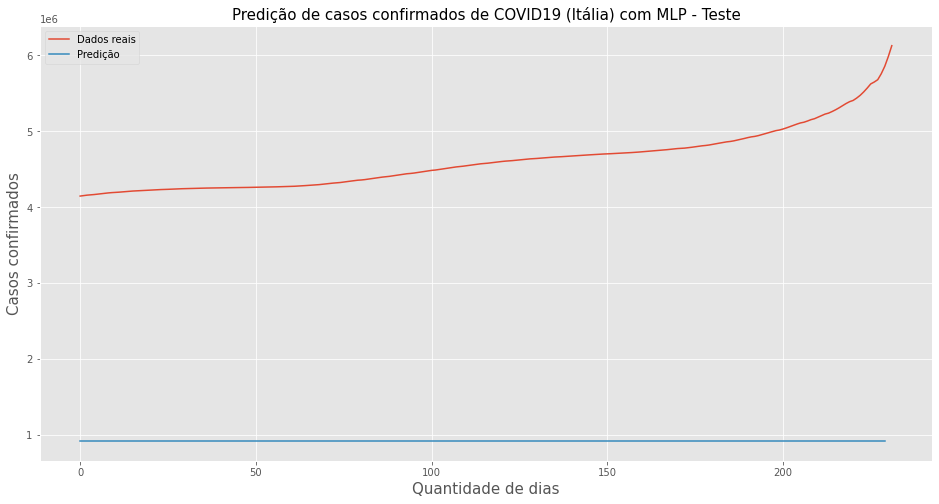

Test Score: 3710220.63 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
MAE: 3691126.277861083
Número de células por camada: 32




 MLP - O melhor caso - EUA 



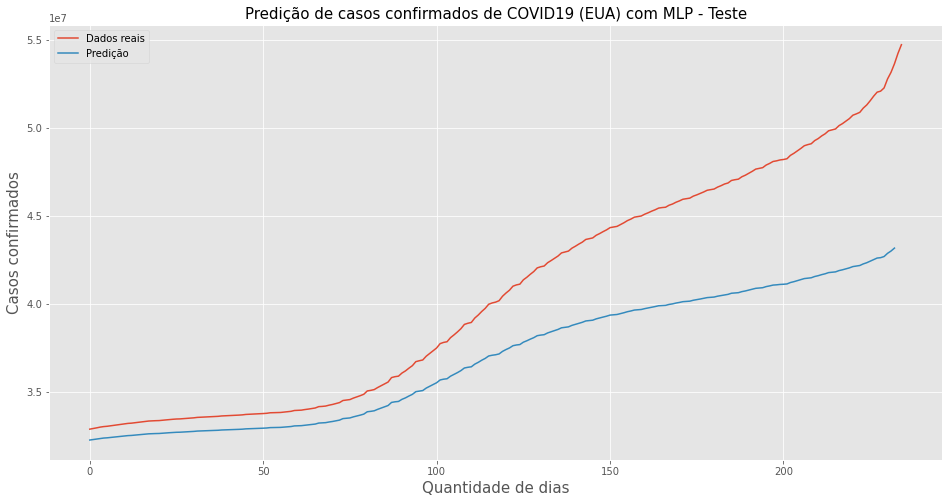

Test Score: 4690290.78 RMSE
MAE: 3722994.6673057373
Taxa de aprendizagem: 0.01
Dropout: 0.01
Número de células por camada: 64

 MLP - O segundo melhor - EUA 



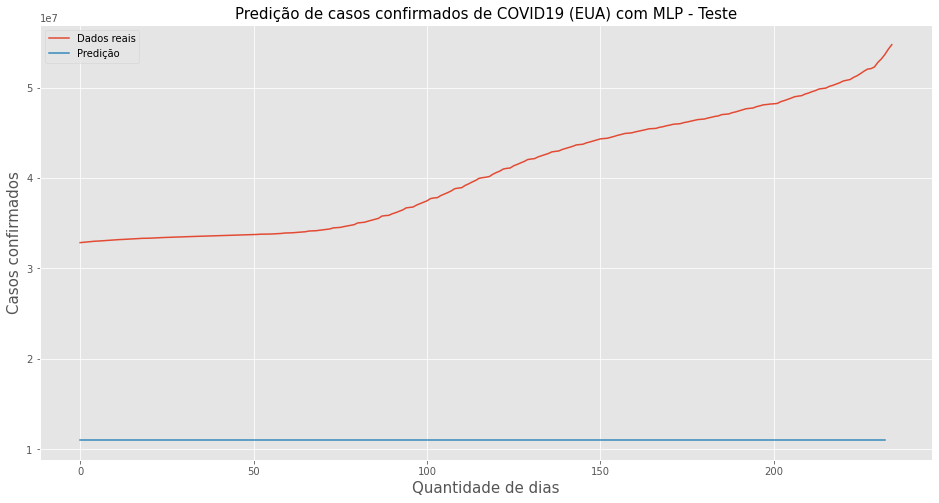

Test Score: 30267324.44 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
MAE: 29588347.156576123
Número de células por camada: 64





In [29]:
#Plotar gráficos com testes do modelo MLP
for i in range(len(country)):
    print('\n MLP - O melhor caso - %s \n' %(country[i]))
    plt.figure(figsize=(16,8))
    plt.title('Predição de casos confirmados de COVID19 (%s) com MLP - Teste' %(country[i]), size = 15)
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Quantidade de dias', size = 15)
    plt.plot(testP[country[i]], label = 'Dados reais')
    plt.plot(stestPredMLP[country[i]], label = 'Predição')
    plt.legend()
    plt.show()

    print('Test Score: %.2f RMSE' % (stssMLP[country[i]]))
    print('MAE:', stsmMLP[country[i]])
    print('Taxa de aprendizagem:', st_aMLP[country[i]])
    print('Dropout:', sdropoutMLP[country[i]])
    print('Número de células por camada:',sn_neu[country[i]])


    print('\n MLP - O segundo melhor - %s \n' %(country[i]))
    plt.figure(figsize=(16,8))
    plt.title('Predição de casos confirmados de COVID19 (%s) com MLP - Teste' %(country[i]), size = 15)
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Quantidade de dias', size = 15)
    plt.plot(testP[country[i]], label = 'Dados reais')
    plt.plot(testPredMLP[country[i]], label = 'Predição')
    plt.legend()
    plt.show()

    print('Test Score: %.2f RMSE' % (tssMLP[country[i]]))
    print('Taxa de aprendizagem:', t_aMLP[country[i]])
    print('Dropout:', dropoutMLP[country[i]])
    print('MAE:', tsmMLP[country[i]])
    print('Número de células por camada:',n_neu[country[i]])
 
    print('\n\n')


 MLP - O melhor caso - Brasil 



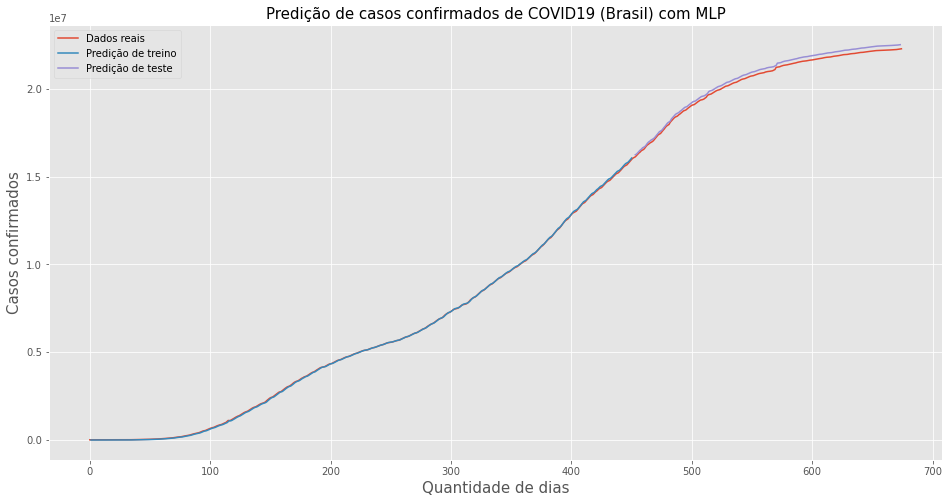

Train Score: 956955.99 RMSE
Test Score: 728409.38 RMSE
MAE: 628033.4209666422
Taxa de aprendizagem: 0.1
Dropout: 0.2
Número de células por camada: 8

 MLP - O segundo melhor - Brasil 



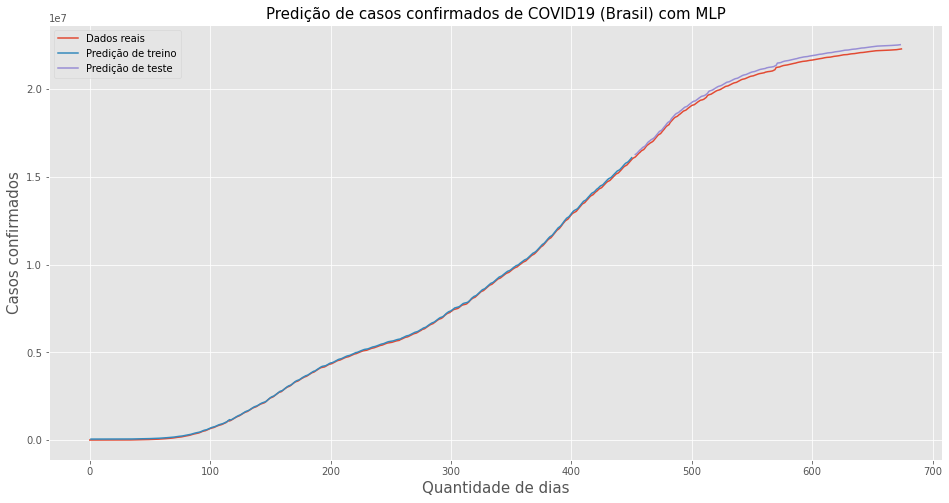

Train Score: 4970356.79 RMSE
Test Score: 13475018.71 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
MAE: 13365020.022776594
Número de células por camada: 8




 MLP - O melhor caso - Índia 



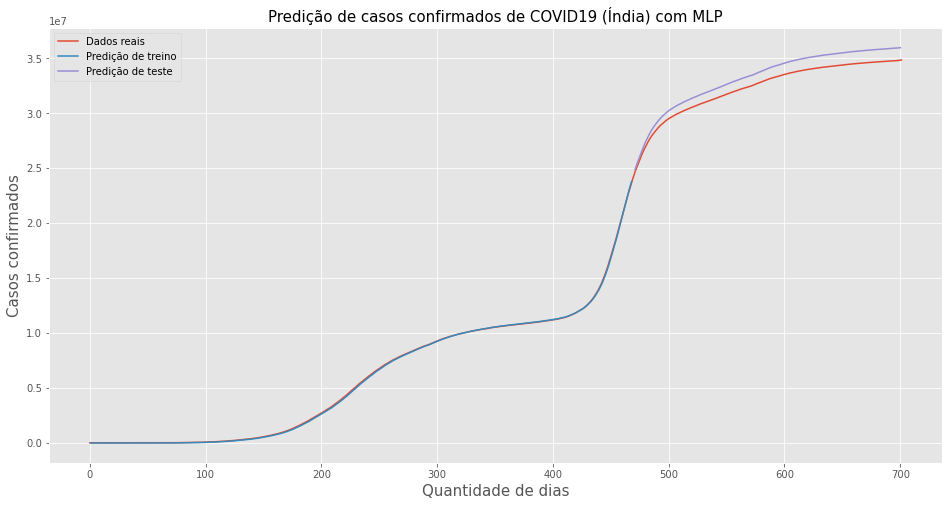

Train Score: 567785.85 RMSE
Test Score: 778756.96 RMSE
MAE: 616552.0811606005
Taxa de aprendizagem: 0.05
Dropout: 0.1
Número de células por camada: 16

 MLP - O segundo melhor - Índia 



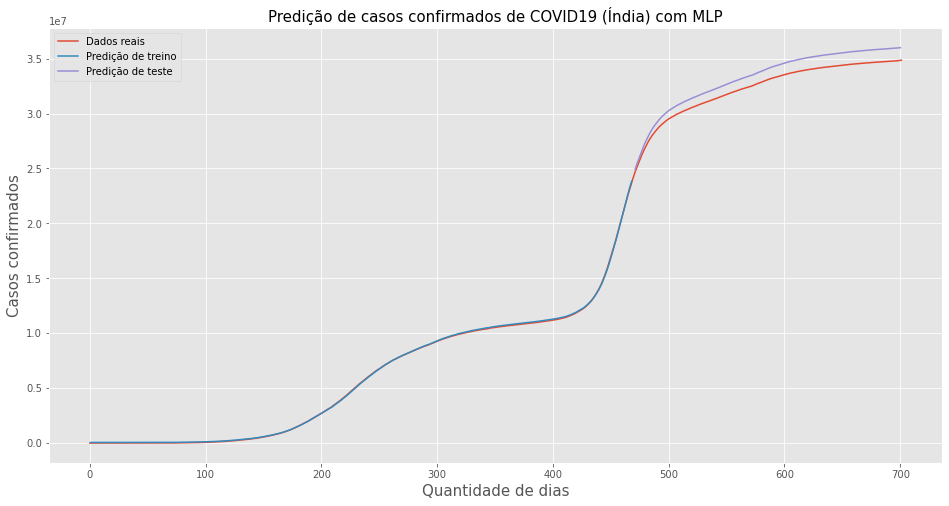

Train Score: 5815261.49 RMSE
Test Score: 27797348.20 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
MAE: 27695077.277159996
Número de células por camada: 16




 MLP - O melhor caso - Itália 



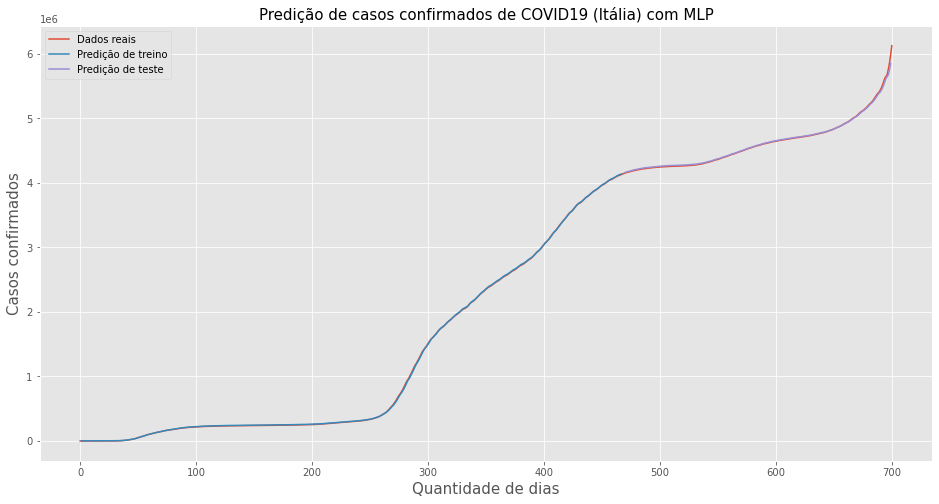

Train Score: 64537.91 RMSE
Test Score: 123301.96 RMSE
MAE: 78405.04347418065
Taxa de aprendizagem: 0.01
Dropout: 0.01
Número de células por camada: 32

 MLP - O segundo melhor - Itália 



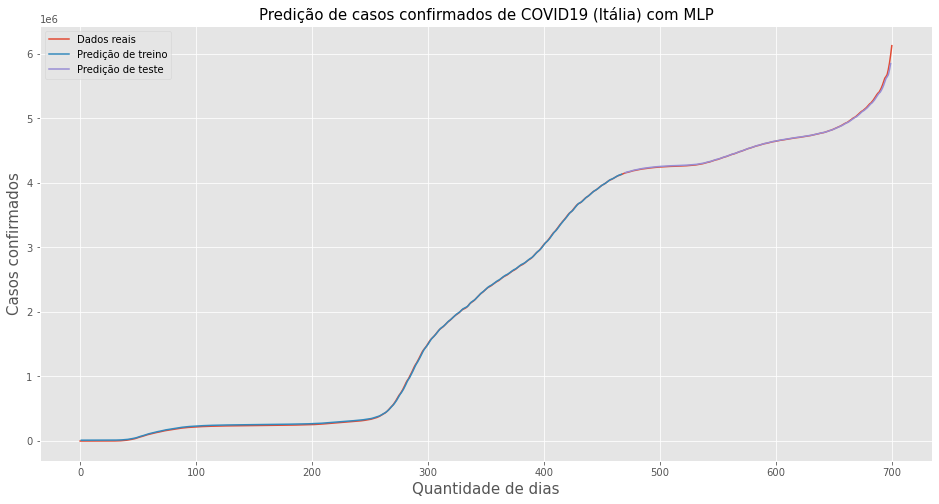

Train Score: 1370134.27 RMSE
Test Score: 3710220.63 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
MAE: 3691126.277861083
Número de células por camada: 32




 MLP - O melhor caso - EUA 



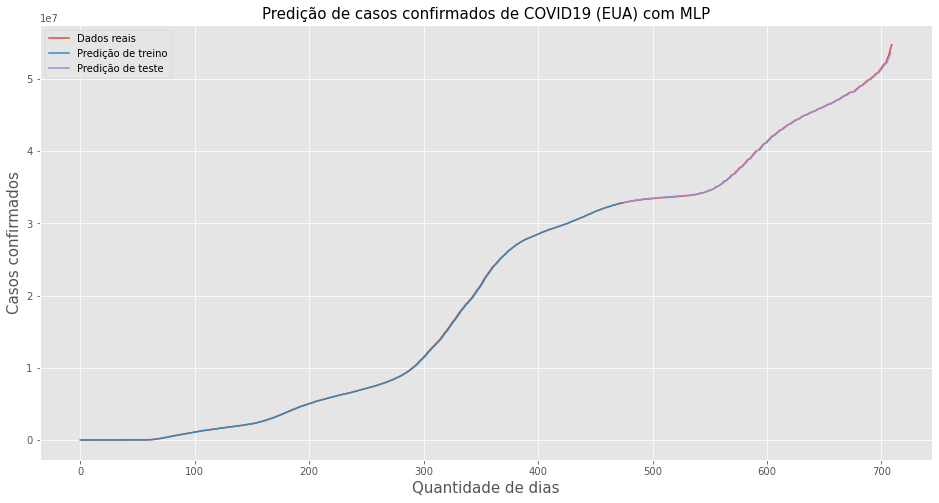

Train Score: 280513.35 RMSE
Test Score: 4690290.78 RMSE
MAE: 3722994.6673057373
Taxa de aprendizagem: 0.01
Dropout: 0.01
Número de células por camada: 64

 MLP - O segundo melhor - EUA 



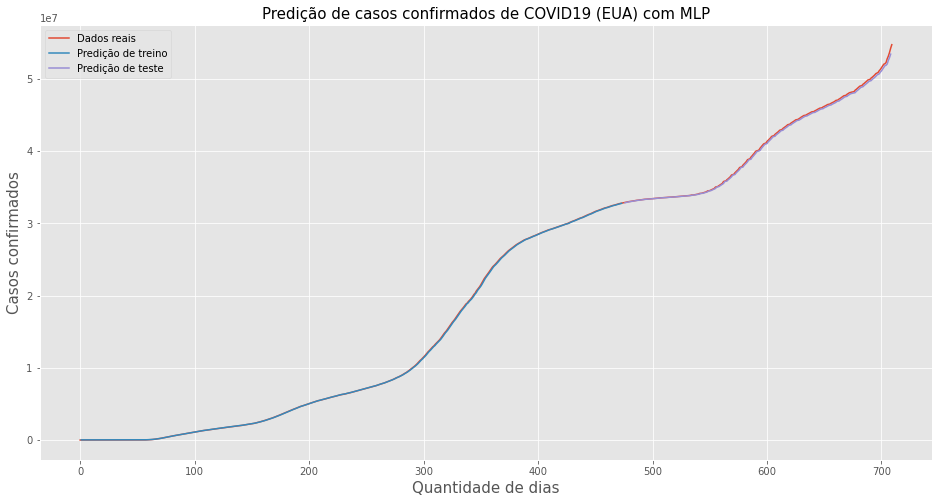

Train Score: 11459562.62 RMSE
Test Score: 30267324.44 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
MAE: 29588347.156576123
Número de células por camada: 64





In [30]:
#Plotar gráficos com base nas previsões do modelo MLP
for i in range(len(country)):
    print('\n MLP - O melhor caso - %s \n' %(country[i]))
    plt.figure(figsize=(16,8))
    plt.title('Predição de casos confirmados de COVID19 (%s) com MLP' %(country[i]), size = 15)
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Quantidade de dias', size = 15)
    plt.plot(dts[country[i]], label = 'Dados reais')
    plt.plot(strppMLP[country[i]], label = 'Predição de treino')
    plt.plot(stsppMLP[country[i]], label = 'Predição de teste')
    plt.legend()
    plt.show()
    print('Train Score: %.2f RMSE' % (strsMLP[country[i]]))
    print('Test Score: %.2f RMSE' % (stssMLP[country[i]]))
    print('MAE:', stsmMLP[country[i]])
    print('Taxa de aprendizagem:', st_aMLP[country[i]])
    print('Dropout:', sdropoutMLP[country[i]])
    print('Número de células por camada:',sn_neu[country[i]])


    print('\n MLP - O segundo melhor - %s \n' %(country[i]))
    plt.figure(figsize=(16,8))
    plt.title('Predição de casos confirmados de COVID19 (%s) com MLP' %(country[i]), size = 15)
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Quantidade de dias', size = 15)
    plt.plot(dts[country[i]], label = 'Dados reais')
    plt.plot(trppMLP[country[i]], label = 'Predição de treino')
    plt.plot(tsppMLP[country[i]], label = 'Predição de teste')
    plt.legend()
    plt.show()
    print('Train Score: %.2f RMSE' % (trsMLP[country[i]]))
    print('Test Score: %.2f RMSE' % (tssMLP[country[i]]))
    print('Taxa de aprendizagem:', t_aMLP[country[i]])
    print('Dropout:', dropoutMLP[country[i]])
    print('MAE:', tsmMLP[country[i]])
    print('Número de células por camada:',n_neu[country[i]])
 
    print('\n\n')
        
    if country[i] == 'Brasil':
        st = strppMLP[country[i]]
        ts = stsppMLP[country[i]]
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/test/out_mlp_casos_test_brazil.csv',st,delimiter=',')
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/train/out_mlp_casos_train_brazil.csv',ts,delimiter=',')
    if country[i] == 'Índia':
        st = strppMLP[country[i]]
        ts = stsppMLP[country[i]]
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/test/out_mlp_casos_test_india.csv',st,delimiter=',')
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/train/out_mlp_casos_train_india.csv',ts,delimiter=',')
    if country[i] == 'Itália':
        st = strppMLP[country[i]]
        ts = stsppMLP[country[i]]
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/test/out_mlp_casos_test_italia.csv',st,delimiter=',')
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/train/out_mlp_casos_train_italia.csv',ts,delimiter=',')
    if country[i] == 'EUA':
        st = strppMLP[country[i]]
        ts = stsppMLP[country[i]]
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/test/out_mlp_casos_test_eua.csv',st,delimiter=',')
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/train/out_mlp_casos_train_eua.csv',ts,delimiter=',')

# Implementação do modelo de Suavização Exponencial (Exponential Smoothing)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred f

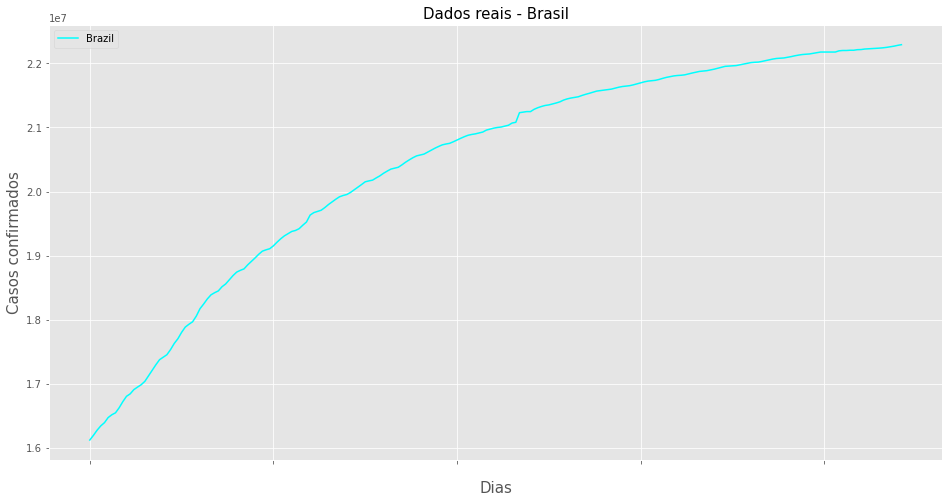

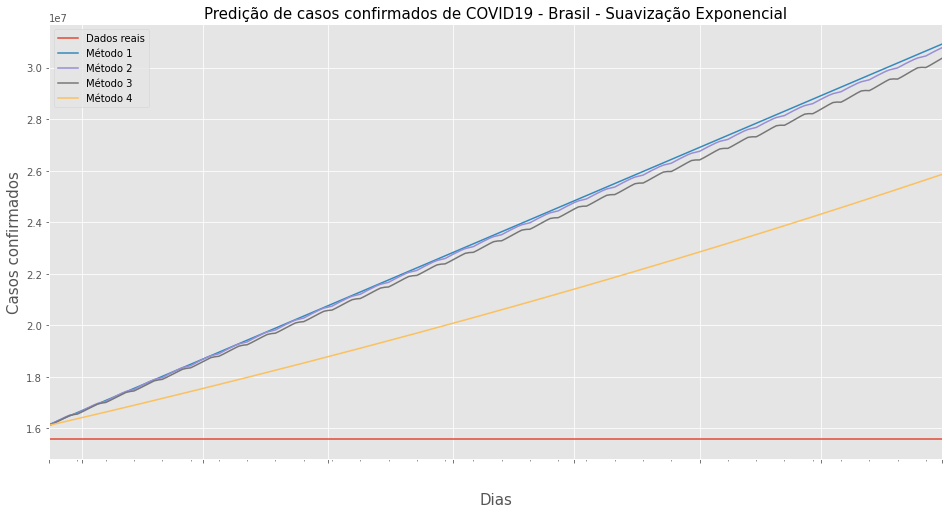

*************Métricas do Algoritmo de Suavização Simples*************
                                                                                                                                                                                                                                                              
Erro médio absoluto do Algoritmo de Suavização Simples : 4878498.845
Raiz do erro médio quadrado do Algoritmo de Suavização Simples : 5173054.763
                                                                                                                                                                                                                                                              
*************Métricas do Algoritmo de Suavização de Holt*************
                                                                                                                                                                                                            

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred f

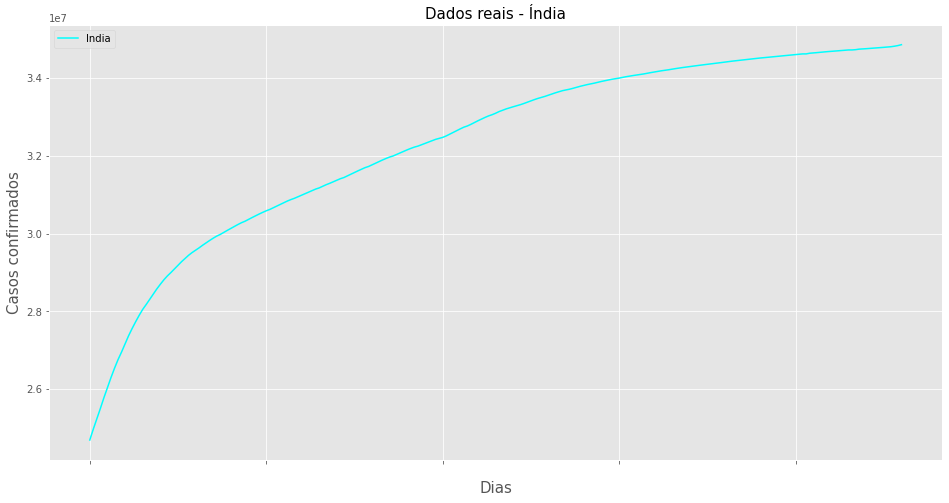

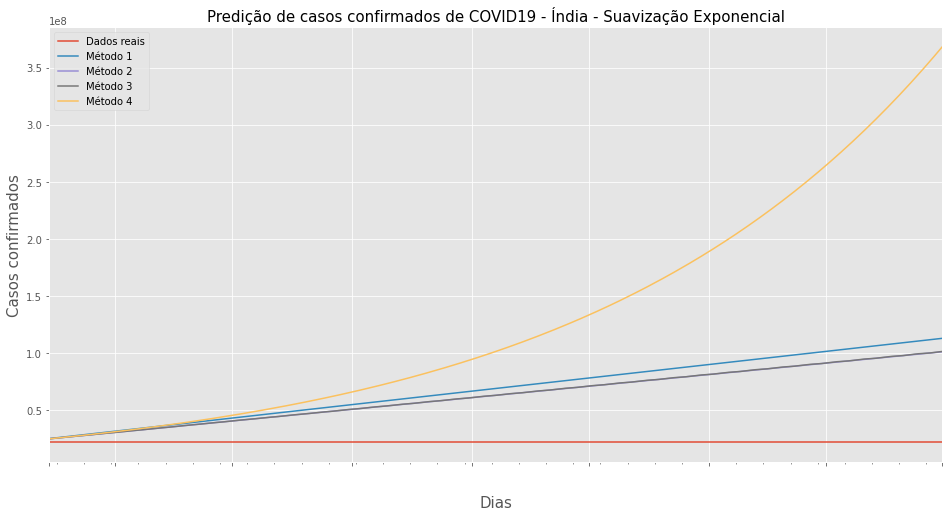

*************Métricas do Algoritmo de Suavização Simples*************
                                                                                                                                                                                                                                                              
Erro médio absoluto do Algoritmo de Suavização Simples : 10789126.506
Raiz do erro médio quadrado do Algoritmo de Suavização Simples : 11049151.887
                                                                                                                                                                                                                                                              
*************Métricas do Algoritmo de Suavização de Holt*************
                                                                                                                                                                                                          

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred f

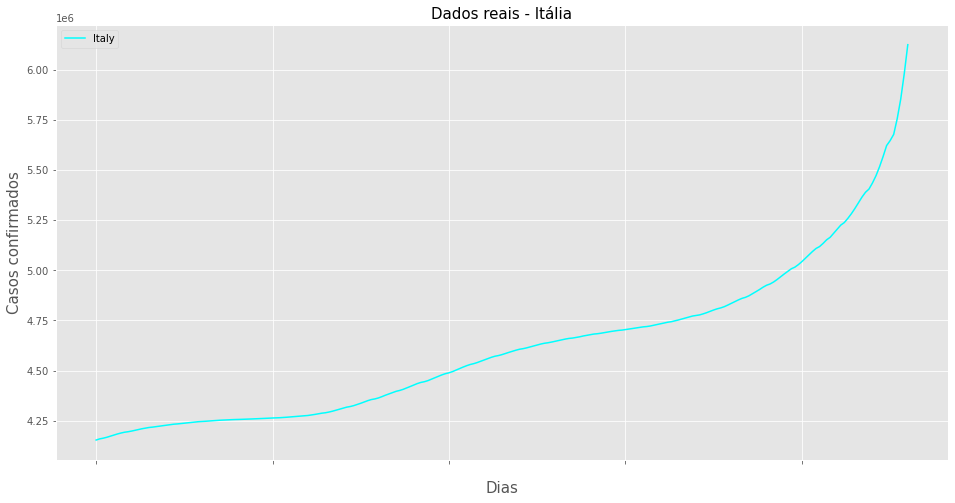

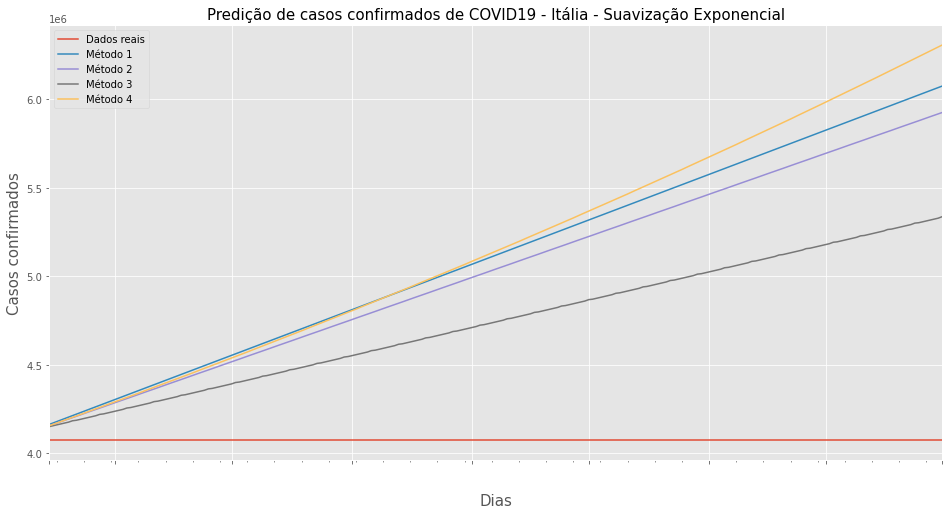

*************Métricas do Algoritmo de Suavização Simples*************
                                                                                                                                                                                                                                                              
Erro médio absoluto do Algoritmo de Suavização Simples : 549365.606
Raiz do erro médio quadrado do Algoritmo de Suavização Simples : 672576.205
                                                                                                                                                                                                                                                              
*************Métricas do Algoritmo de Suavização de Holt*************
                                                                                                                                                                                                              

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred f

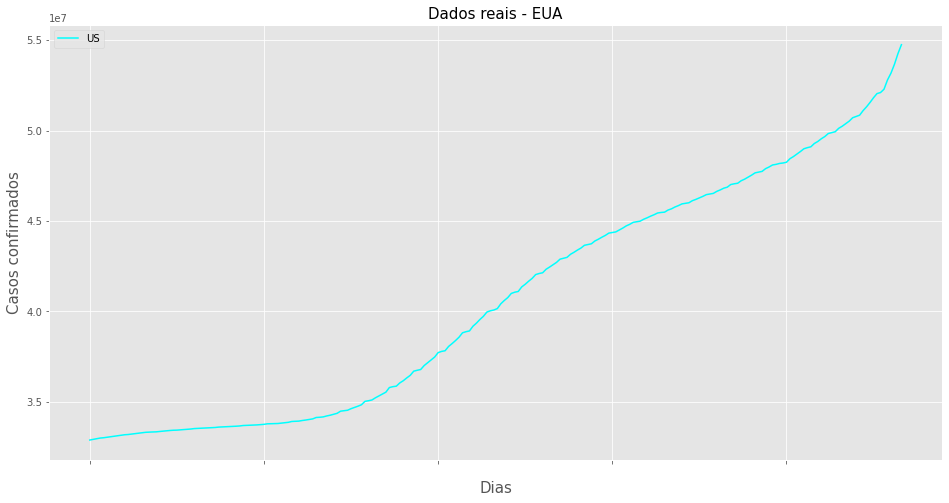

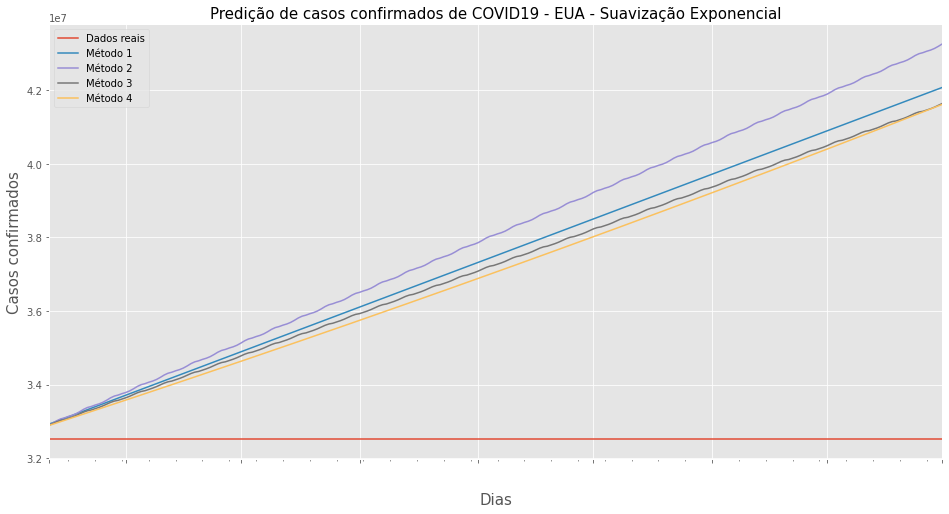

*************Métricas do Algoritmo de Suavização Simples*************
                                                                                                                                                                                                                                                              
Erro médio absoluto do Algoritmo de Suavização Simples : 8163775.06
Raiz do erro médio quadrado do Algoritmo de Suavização Simples : 10389479.592
                                                                                                                                                                                                                                                              
*************Métricas do Algoritmo de Suavização de Holt*************
                                                                                                                                                                                                            

In [3]:
country = ['Brasil', 'Índia', 'Itália', 'EUA'] #Lista de países
for i in range(len(country)):
    if country[i] == "Brasil":
        dataframe = read_csv("datasets/countries/casos_covid19_brazil_date.csv",encoding='utf-8',index_col='date')

    if country[i] == "Índia":
        dataframe = read_csv("datasets/countries/casos_covid19_india_date.csv",encoding='utf-8',index_col='date')
        
    if country[i] == "Itália":
        dataframe = read_csv("datasets/countries/casos_covid19_italy_date.csv",encoding='utf-8',index_col='date')

    if country[i] == "EUA":
        dataframe = read_csv("datasets/countries/casos_covid19_us_date.csv",encoding='utf-8',index_col='date')
    total = len(dataframe)
    t = int(total*0.33)
    treino=dataframe.iloc[:-t]
    teste=dataframe.iloc[-t:]
    
    #Implementando modelos
    model1=SimpleExpSmoothing(treino).fit(smoothing_level=0.111,optimized=True)
    modelo1=model1.forecast(len(teste))
    model2=Holt(treino).fit(smoothing_level=0.2)
    modelo2=model2.forecast(len(teste))
    model3=ExponentialSmoothing(treino,trend='add',seasonal='add').fit()
    modelo3=model3.forecast(len(teste))
    model4=ExponentialSmoothing(treino,trend='add',seasonal='mul').fit()
    modelo4=model4.forecast(len(teste))
    model5=ExponentialSmoothing(treino,trend='mul',seasonal='add').fit()
    modelo5=model5.forecast(len(teste))

    #Plotando testes
    teste.plot(figsize=(16,8), color = 'cyan')
    plt.title('Dados reais - %s' %(country[i]), size = 15)
    plt.xticks(color='w')
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Dias', size = 15)
    plt.show()


    modelo1.plot(figsize=(16,8))
    modelo2.plot()
    modelo3.plot()
    modelo4.plot()
    modelo5.plot()
    plt.title('Predição de casos confirmados de COVID19 - %s - Suavização Exponencial' %(country[i]), size = 15)
    plt.xticks(color='w')
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Dias', size = 15)
    lista=['Dados reais','Método 1','Método 2','Método 3','Método 4','Método 5']
    plt.legend(lista)
    plt.show()
    
    print('*************Métricas do Algoritmo de Suavização Simples*************')
    print(' '*254)
    print('Erro médio absoluto do Algoritmo de Suavização Simples :',round(mean_absolute_error(teste,modelo1),3))
    print('Raiz do erro médio quadrado do Algoritmo de Suavização Simples :',round(mean_squared_error(teste,modelo1)**0.5,3))


    print(' '*254)
    print('*************Métricas do Algoritmo de Suavização de Holt*************')
    print(' '*254)
    print('Erro médio absoluto do Algoritmo de Suavização Holt:',round(mean_absolute_error(teste,modelo2),3))
    print('Raiz do erro médio quadrado do Algoritmo de Suavização',round(mean_squared_error(teste,modelo2)**0.5,3))

    print(' '*254)
    print('*************Métricas do Algoritmo de Suavização de Holt-Winters aditivo*************')
    print(' '*254)
    print('Erro médio absoluto do Algoritmo de Suavização Holt-Winters aditivo :', round(mean_absolute_error(teste,modelo3),3))
    print('Raiz do erro médio quadrado do Algoritmo de Suavização Holt-Winters aditivo :',round(mean_squared_error(teste,modelo3)**0.5,3))

    print(' '*254)
    print('*************Métricas do Algoritmo de Suavização de Holt-Winters multiplicativo*************')
    print(' '*254)
    print('Erro médio absoluto do Algoritmo de Suavização Holt-Winters multiplicativo :',round(mean_absolute_error(teste,modelo4),3))
    print('Raiz do erro médio quadrado do Algoritmo de Suavização Holt-Winters multiplicativo :',round(mean_squared_error(teste,modelo4)**0.5,3))

    print(' '*254)
    print('*************Métricas do Algoritmo de Suavização de Pegels aditivo *************')
    print(' '*254)
    print('Erro médio absoluto do Algoritmo de Suavização Pegels aditivo :',round(mean_absolute_error(teste,modelo5),3))
    print('Raiz do erro médio quadrado do Algoritmo de Suavização Pegels aditivo :',round(mean_squared_error(teste,modelo5)**0.5,3))

    print(' '*254)

# Implementação do Modelo ARIMA

In [4]:
#Criando dicionários
preds = dict()
outtest = dict()
outtrain = dict()
rmses = dict()
rmses_t = dict()
trainss = dict()
maes = dict()
country = ['Brasil', 'Índia', 'Itália', 'EUA'] #Lista de países

In [14]:
#Verificando melhores parâmetros (p,d,q)
from pmdarima.arima import auto_arima

for i in range(len(country)):
    if country[i] == "Brasil":
        dataframe = read_csv("datasets/countries/casos_covid19_brazil_date.csv",encoding='utf-8',index_col='date')

    if country[i] == "Índia":
        dataframe = read_csv("datasets/countries/casos_covid19_india_date.csv",encoding='utf-8',index_col='date')
        
    if country[i] == "Itália":
        dataframe = read_csv("datasets/countries/casos_covid19_italy_date.csv",encoding='utf-8',index_col='date')

    if country[i] == "EUA":
        dataframe = read_csv("datasets/countries/casos_covid19_us_date.csv",encoding='utf-8',index_col='date')
    bruteforce_modelo = auto_arima(dataframe, start_p=0, start_d=0 ,start_q=0,max_p=8, max_d=8,max_q=8, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',suppress_warnings=True, stepwise=False)
    print('Resultados do ', country[i])
    print(f"Resultado AIC: {bruteforce_modelo.aic()}")
    print(f"Melhores parâmetros (p,d,q): {bruteforce_modelo.order}")


 ARIMA(0,1,0)(0,1,0)[12]             : AIC=15215.844, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=15006.573, Time=0.35 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=15011.212, Time=0.72 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=15101.537, Time=0.20 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=14995.629, Time=0.50 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=14994.996, Time=1.99 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=14910.414, Time=0.62 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=14902.436, Time=0.97 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=14871.836, Time=1.97 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=15152.093, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=14925.483, Time=0.50 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=14919.849, Time=1.16 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=15012.041, Time=0.43 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=14923.421, Time=0.78 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=14917

 ARIMA(0,1,2)(2,1,0)[12]             : AIC=15861.108, Time=1.14 sec
 ARIMA(0,1,2)(2,1,1)[12]             : AIC=inf, Time=2.71 sec
 ARIMA(0,1,3)(0,1,0)[12]             : AIC=inf, Time=3.67 sec
 ARIMA(0,1,3)(0,1,1)[12]             : AIC=inf, Time=3.48 sec
 ARIMA(0,1,3)(0,1,2)[12]             : AIC=inf, Time=4.72 sec
 ARIMA(0,1,3)(1,1,0)[12]             : AIC=inf, Time=3.04 sec
 ARIMA(0,1,3)(1,1,1)[12]             : AIC=inf, Time=4.40 sec
 ARIMA(0,1,3)(2,1,0)[12]             : AIC=inf, Time=8.11 sec
 ARIMA(0,1,4)(0,1,0)[12]             : AIC=15810.410, Time=1.14 sec
 ARIMA(0,1,4)(0,1,1)[12]             : AIC=15812.409, Time=2.50 sec
 ARIMA(0,1,4)(1,1,0)[12]             : AIC=15812.409, Time=1.99 sec
 ARIMA(0,1,5)(0,1,0)[12]             : AIC=15816.246, Time=2.97 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=14678.466, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=2.11 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=4.75 sec
 ARIMA(1,1,0)(1,1,0)[12]          

 ARIMA(1,1,2)(0,1,0)[12]             : AIC=13391.011, Time=0.67 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=4.19 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=inf, Time=8.34 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=13304.841, Time=2.28 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=inf, Time=7.33 sec
 ARIMA(1,1,2)(2,1,0)[12]             : AIC=13225.937, Time=8.53 sec
 ARIMA(1,1,3)(0,1,0)[12]             : AIC=inf, Time=2.69 sec
 ARIMA(1,1,3)(0,1,1)[12]             : AIC=inf, Time=5.78 sec
 ARIMA(1,1,3)(1,1,0)[12]             : AIC=13289.670, Time=1.87 sec
 ARIMA(1,1,4)(0,1,0)[12]             : AIC=13370.542, Time=1.33 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=13420.712, Time=0.10 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=2.61 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=inf, Time=5.52 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=13306.259, Time=3.67 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.97 sec
 ARIMA(2,1,0)(1,1,2)[12]    

 ARIMA(3,1,0)(0,1,0)[12]             : AIC=16997.671, Time=0.26 sec
 ARIMA(3,1,0)(0,1,1)[12]             : AIC=inf, Time=2.09 sec
 ARIMA(3,1,0)(0,1,2)[12]             : AIC=inf, Time=4.47 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=16926.032, Time=1.19 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=inf, Time=2.92 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=16891.362, Time=2.73 sec
 ARIMA(3,1,1)(0,1,0)[12]             : AIC=16999.645, Time=0.34 sec
 ARIMA(3,1,1)(0,1,1)[12]             : AIC=inf, Time=5.55 sec
 ARIMA(3,1,1)(1,1,0)[12]             : AIC=16877.839, Time=6.47 sec
 ARIMA(3,1,2)(0,1,0)[12]             : AIC=16745.815, Time=1.41 sec
 ARIMA(4,1,0)(0,1,0)[12]             : AIC=16999.624, Time=0.49 sec
 ARIMA(4,1,0)(0,1,1)[12]             : AIC=inf, Time=2.69 sec
 ARIMA(4,1,0)(1,1,0)[12]             : AIC=16925.552, Time=1.85 sec
 ARIMA(4,1,1)(0,1,0)[12]             : AIC=16996.099, Time=1.51 sec
 ARIMA(5,1,0)(0,1,0)[12]             : AIC=16982.031, Time=0.92 sec

Best mode

In [5]:
#Parâmetros
p = {'Brasil':2, 'Índia':3, 'Itália':1, 'EUA':1}
d = {'Brasil':1, 'Índia':1, 'Itália':1, 'EUA':1}
q = {'Brasil':2, 'Índia':0, 'Itália':1, 'EUA':3}

# load dataset
for i in range(len(country)):
    if country[i] == 'Brasil':
        series = read_csv('datasets/countries/casos_covid19_brazil.csv', usecols=[1], engine='python')
    if country[i] == 'Índia':
        series = read_csv('datasets/countries/casos_covid19_india.csv', usecols=[1], engine='python')
    if country[i] == 'Itália':
        series = read_csv('datasets/countries/casos_covid19_italy.csv', usecols=[1], engine='python')
    if country[i] == 'EUA':
        series = read_csv('datasets/countries/casos_covid19_us.csv', usecols=[1], engine='python')
    # split into train and test sets
    X = series.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    trains = list()
    predictions = list()
    history = [x for x in train]
    # walk-forward validation
    for t in range(len(train)):
        #model = ARIMA(history, order=(p[country[i]],d[country[i]],q[country[i]]))
        model = ARIMA(history, order=(1,0,1))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        trains.append(yhat)
        obs = train[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
        # evaluate forecasts
    for t in range(len(test)):
        #model = ARIMA(history, order=(p[country[i]],d[country[i]],q[country[i]]))
        model = ARIMA(history, order=(1,0,1))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
        # evaluate forecasts
    mae = mean_absolute_error(test, predictions)
    rmse_t = math.sqrt(mean_squared_error(train, trains))
    rmse = math.sqrt(mean_squared_error(test, predictions))
    maes[country[i]] = mae
    rmses[country[i]] = rmse
    rmses_t[country[i]] = rmse_t
    trainss[country[i]] = trains
    preds[country[i]] = predictions
    outtest[country[i]] = test
    outtrain[country[i]] = train

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramDat

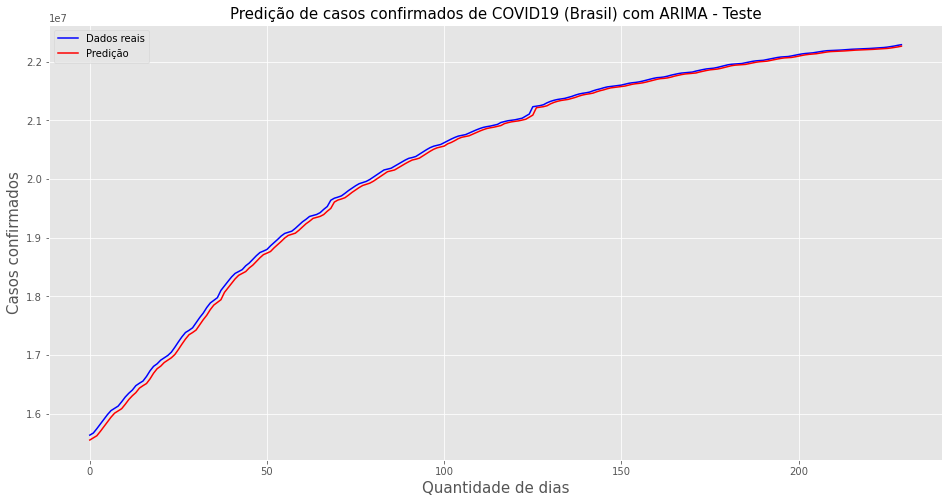

Test RMSE: 63678.261


Test MAE: 53795.276


p: 2 d: 1 q: 2


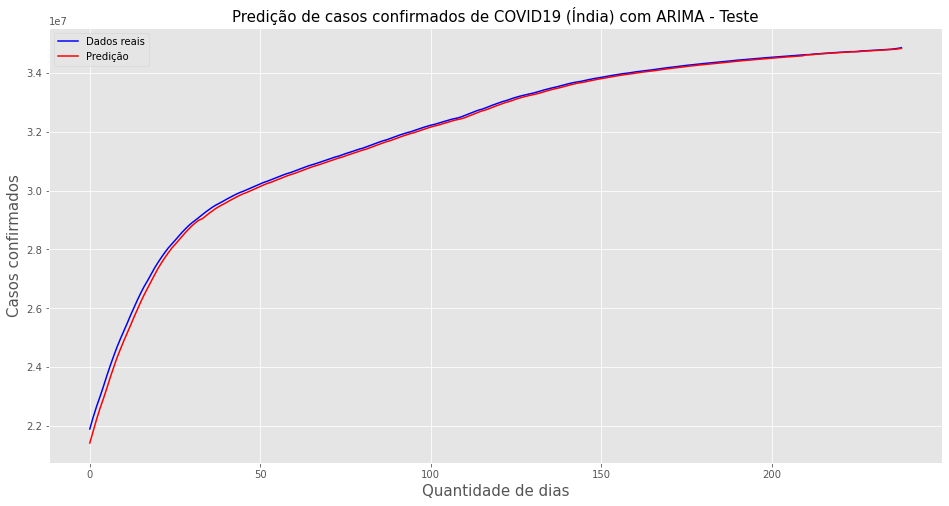

Test RMSE: 123250.869


Test MAE: 83382.792


p: 3 d: 1 q: 0


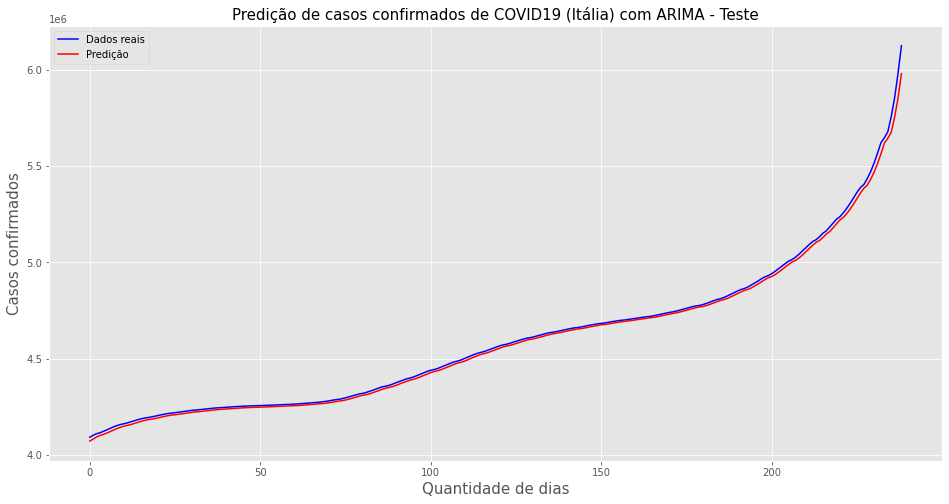

Test RMSE: 20962.274


Test MAE: 14615.945


p: 1 d: 1 q: 1


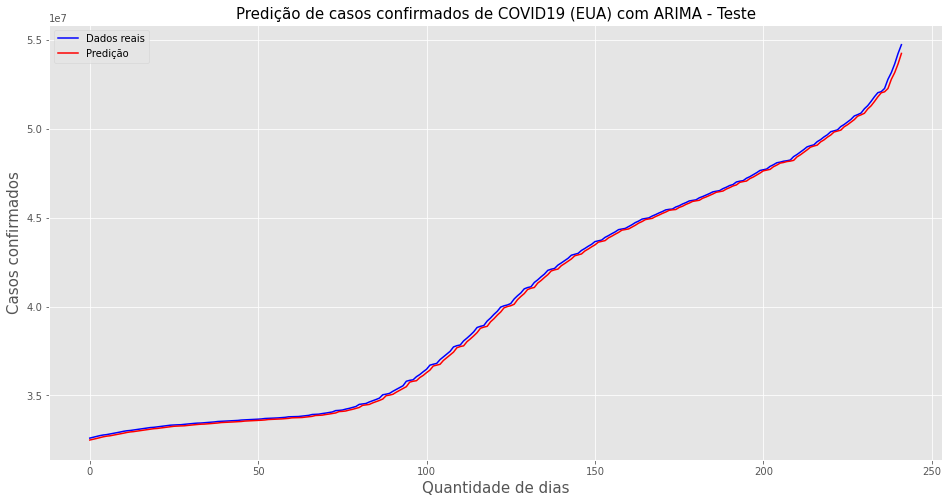

Test RMSE: 155104.608


Test MAE: 132354.435


p: 1 d: 1 q: 3


In [14]:
#Plotando testes
for i in range(len(country)):
    plt.figure(figsize=(16,8))
    plt.title('Predição de casos confirmados de COVID19 (%s) com ARIMA - Teste' %(country[i]), size = 15)
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Quantidade de dias', size = 15)
    plt.plot(outtest[country[i]], label = 'Dados reais', color = 'blue')
    plt.plot(preds[country[i]], label = 'Predição', color='red')
    plt.legend()
    plt.show()
    print('Test RMSE: %.3f\n\n' % rmses[country[i]])
    print('Test MAE: %.3f\n\n' % maes[country[i]])
    print("p:", p[country[i]],"d:",d[country[i]],"q:",q[country[i]])
    
    #Armazenando predições
    if country[i] == 'Brasil':
        st = preds[country[i]]
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/test/out_arima_casos_test_brazil.csv',st,delimiter=',')
        
    if country[i] == 'Índia':
        st = preds[country[i]]
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/test/out_arima_casos_test_india.csv',st,delimiter=',')
            
    if country[i] == 'Itália':
        st = preds[country[i]]
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/test/out_arima_casos_test_italia.csv',st,delimiter=',')
           
    if country[i] == 'EUA':
        st = preds[country[i]]
        numpy.savetxt('C:/Users/Saulo Joel/GitHub/COVID-19-time-series-predictions/outputs/test/out_mlp_casos_test_eua.csv',st,delimiter=',')
            

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 Brazil   No. Observations:                  675
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7340.050
Date:                Thu, 06 Jan 2022   AIC                          14690.100
Time:                        02:20:50   BIC                          14712.666
Sample:                             0   HQIC                         14698.838
                                - 675                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0838      0.069     15.657      0.000       0.948       1.219
ar.L2         -0.0849      0.069     -1.231      0.218      -0.220       0.050
ma.L1         -0.5212      0.070     -7.399      0.0

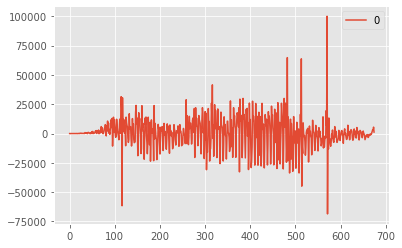

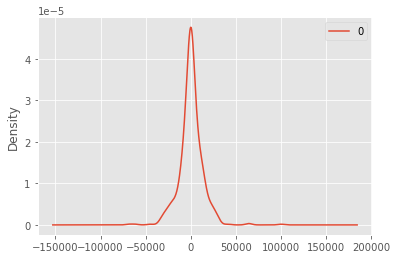

                   0
count     675.000000
mean      350.387266
std     12951.290332
min    -68565.094039
25%     -5082.408847
50%       202.797222
75%      6051.168803
max    100088.157521


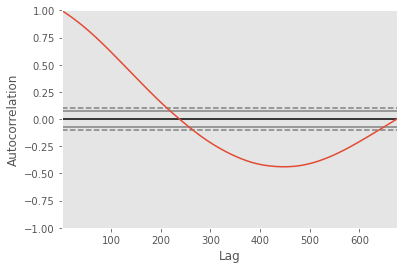

                               SARIMAX Results                                
Dep. Variable:                  India   No. Observations:                  702
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -7187.732
Date:                Thu, 06 Jan 2022   AIC                          14383.463
Time:                        02:20:50   BIC                          14401.673
Sample:                             0   HQIC                         14390.502
                                - 702                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1299      0.016     68.939      0.000       1.098       1.162
ar.L2         -0.1696      0.028     -6.150      0.000      -0.224      -0.116
ar.L3          0.0366      0.021      1.784      0.0

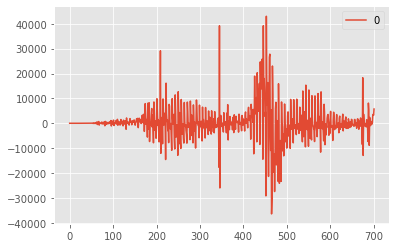

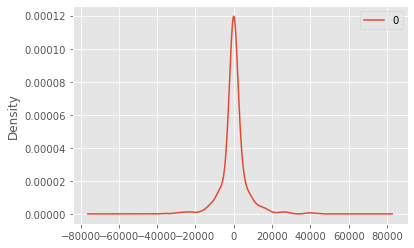

                  0
count    702.000000
mean     185.340394
std     6865.084737
min   -36437.170718
25%    -1592.312335
50%        0.000000
75%     1570.429653
max    43021.949756


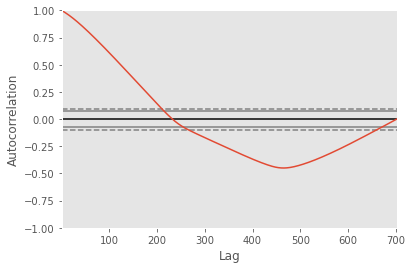

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  Italy   No. Observations:                  701
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6651.219
Date:                Thu, 06 Jan 2022   AIC                          13308.438
Time:                        02:20:51   BIC                          13322.091
Sample:                             0   HQIC                         13313.715
                                - 701                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.004    268.335      0.000       0.993       1.007
ma.L1          0.3379      0.008     40.977      0.000       0.322       0.354
sigma2      1.045e+07   3.08e-10   3.39e+16      0.0

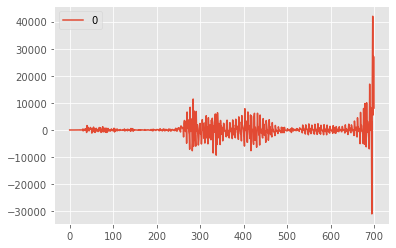

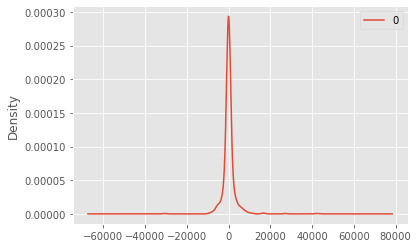

                  0
count    701.000000
mean     156.799608
std     3233.989513
min   -30958.074519
25%     -453.036663
50%       -0.001991
75%      475.945475
max    41966.451051


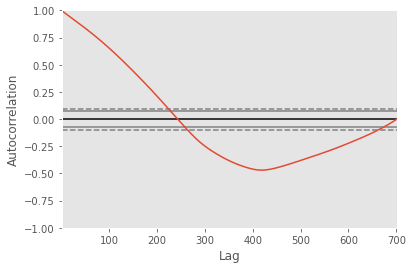

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                     US   No. Observations:                  710
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -8550.544
Date:                Thu, 06 Jan 2022   AIC                          17111.088
Time:                        02:20:52   BIC                          17133.908
Sample:                             0   HQIC                         17119.904
                                - 710                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7637      0.018     42.747      0.000       0.729       0.799
ma.L1          0.0847      0.013      6.434      0.000       0.059       0.110
ma.L2          0.3126      0.013     24.002      0.0

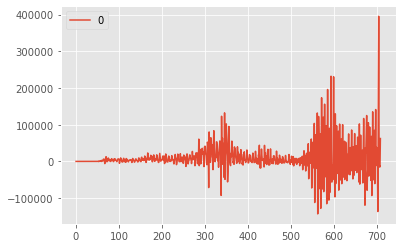

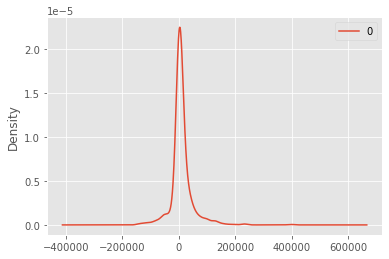

                   0
count     710.000000
mean     9457.464798
std     39620.406566
min   -143110.539667
25%     -1273.245393
50%      3808.085560
75%     14912.951838
max    395642.907946


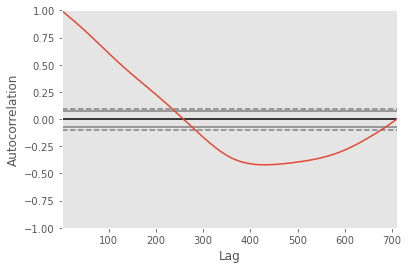

In [28]:
#Análise dos dados com ARIMA
country = ['Brasil', 'Índia', 'Itália', 'EUA'] #Lista de países
for i in range(len(country)):
    if country[i] == 'Brasil':
        series = read_csv('datasets/countries/casos_covid19_brazil.csv', usecols=[1], engine='python')
    if country[i] == 'Índia':
        series = read_csv('datasets/countries/casos_covid19_india.csv', usecols=[1], engine='python')
    if country[i] == 'Itália':
        series = read_csv('datasets/countries/casos_covid19_italy.csv', usecols=[1], engine='python')
    if country[i] == 'EUA':
        series = read_csv('datasets/countries/casos_covid19_us.csv', usecols=[1], engine='python')
    model = ARIMA(series, order=(p[country[i]],d[country[i]],q[country[i]]))
    model_fit = model.fit()
    model_fit = model.fit()
    output = model_fit.forecast()
    # summary of fit model
    print(model_fit.summary())
    # line plot of residuals
    residuals = pandas.DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()
    # density plot of residuals
    residuals.plot(kind='kde')
    plt.show()
    # summary stats of residuals
    print(residuals.describe())
    autocorrelation_plot(series)
    plt.show()